# Vehicle Dynamics Simulator
**Contributors:** Shengfan Cao, Edward Zhu, Thomas Fork.

##Clone repository and Install Dependencies

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
if "dependencies_installed" not in globals():
    !git clone https://github.com/MPC-Berkeley/barc_gym.git --depth 1
    !pip install -r barc_gym/requirements.txt
    !pip install -e barc_gym/gym-carla
    !pip install -e barc_gym/mpclab_common
    !pip install -e barc_gym/mpclab_controllers
    !pip install -e barc_gym/mpclab_simulation
    dependencies_installed = True

fatal: destination path 'barc_gym' already exists and is not an empty directory.
Obtaining file:///Users/edwardwang/Library/CloudStorage/OneDrive-Personal/Edward%20doc/Berkeley%20docs/eecs%20106b/final%20project/EECS-C106B-Final-Project/barc_gym/gym-carla
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gym_carla
    Found existing installation: gym_carla 0.0.1
    Uninstalling gym_carla-0.0.1:
      Successfully uninstalled gym_carla-0.0.1
  DEPRECATION: Legacy editable install of gym_carla==0.0.1 from file:///Users/edwardwang/Library/CloudStorage/OneDrive-Personal/Edward%20doc/Berkeley%20docs/eecs%20106b/final%20project/EECS-C106B-Final-Project/barc_gym/gym-carla (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the set

In [ ]:
# import site
# import warnings
# site.main()
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
import numpy as np
import gymnasium as gym
import gym_carla
from matplotlib import pyplot as plt
from loguru import logger
import casadi as ca

/Users/edwardwang/Library/CloudStorage/OneDrive-Personal/Edward doc/Berkeley docs/eecs 106b/final project/EECS-C106B-Final-Project/barc_gym/mpclab_common/mpclab_common/tracks/surface_lib.py:16: UserWarning: Barc3d is not available.
  warnings.warn("Barc3d is not available.")
/Users/edwardwang/Library/CloudStorage/OneDrive-Personal/Edward doc/Berkeley docs/eecs 106b/final project/EECS-C106B-Final-Project/barc_gym/mpclab_common/mpclab_common/track.py:22: UserWarning: surface_lib functions import failed, possibly due to the absense of barc3d package.
  warnings.warn("surface_lib functions import failed, possibly due to the absense of barc3d package.")
/Users/edwardwang/Library/CloudStorage/OneDrive-Personal/Edward doc/Berkeley docs/eecs 106b/final project/EECS-C106B-Final-Project/barc_gym/mpclab_common/mpclab_common/models/model_types.py:13: UserWarning: Barc3d is not available.
  warnings.warn("Barc3d is not available.")
/Users/edwardwang/Library/CloudStorage/OneDrive-Personal/Edward doc

#Instructions

##Introduction
For your final project, you will design a controller to race a BARC (Berkeley Autonomous Race Car) around the track in the MPC Lab.

This will be done in two parts

*   First you will compute the optimal raceline that minimizes the lap time for a car to race around the track with the inputs of steering and acceleration and references of speed and centerline offset.
*   You will then design PID controllers for steering and acceleration to follow that raceline.

Your goal is to acheive the fastest lap time (you can chose which lap, for example if your lap 3 is faster than lap 1 or lap 2, your fastest lap time is from lap 3).



##Instructions for Computing the Raceline
The optimization method for computing your raceline is provided. The raceline is given in terms of

*   s (curvilinear abscissa)  
*   ey (lateral offset from centerline as a function of s)
*   vx (longitudinal velocity as a function of s)
*   vy (lateral velocity as a function of s)
*   epsi_dot (heading angle rate of change as a function of s)
*   epsi (heading angle as a function of s)
*   t (time as a function of s)
*   u0 (acceleration input as a function of s)
*   u1 (steering input as a function of s)

Your task is to adjust the parameters in the optimization to achieve your desired raceline. It is also recommended that you edit the track tightening and the speed scaling. Keep in mind that the implemented vehicle model may not exaclty represent the actual vehicle being used. These can be found in the code under the following comments:
```
###[1] Parameters, ###[2] Track Tightening, and ###[3] Speed Scaling  
```
The optimization process will take a few minutes (this should take less than 200 iterations). After it is over, your optimal raceline will be automatically saved into the Colab environment as well as on your machine as an NPZ file with the values of s, ey, vx, vy, epsi_dot, epsi, t, u0, and u1.








##Instructions for Creating the PID Controllers

You will have to create two PID controllers to follow the raceline computed. One for speed control and one for path following. Your inputs will be longitudinal acceleration and steering angle. You will modify the `solve()` method inside the `PIDRacelineFollower` class.

You can find a similar Colab notebook in Ed Discussions where the car is following a raceline that has the track centerline as the path reference and a constant velocity of 1 m/s as the speed reference.

Your NPZ file containing the raceline will be loaded with all of the states stored into a dictionary. Your task is to tune the PID parameters and implement the control logic that will have the car follow your reference path and speed around the track.

PID gains can be changed under Tuning the Gains and the control logic can be implemented in the step function found at
```
###[4] Control Logic
```

#Computing the Raceline

##Dependencies

In [ ]:
# pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#   !apt-get install -y -qq glpk-utils
#   !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
#   !unzip -o -q ipopt-linux64

##Parameters and Vehicle Dynamics

In [7]:
# Original code at: https://github.com/MPC-Berkeley/barc_gym/blob/main/mpclab_common/mpclab_common/tracks/solve_raceline.py

import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd

from mpclab_common.pytypes import BodyAngularVelocity, BodyLinearVelocity, ParametricPose, VehicleState, VehicleActuation

def compute_raceline(track, vehicle_config, vehicle_constraints,
                     obj_num=0,
                     raceline_to_avoid=None,
                     track_tightening=0,
                     constant_width=False):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steering(rad)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config.wheel_dist_front
    lr = vehicle_config.wheel_dist_rear

    mass = vehicle_config.mass
    Iz = vehicle_config.yaw_inertia

    tire_model = vehicle_config.tire_model

    mu = vehicle_config.wheel_friction
    Br = vehicle_config.pacejka_b_rear
    Bf = vehicle_config.pacejka_b_front
    Cr = vehicle_config.pacejka_c_rear
    Cf = vehicle_config.pacejka_c_front
    Dr = vehicle_config.pacejka_d_rear
    Df = vehicle_config.pacejka_d_front

    xu_ub = vehicle_constraints['xu_ub']
    xu_lb = vehicle_constraints['xu_lb']
    du_ub = vehicle_constraints['du_ub']
    du_lb = vehicle_constraints['du_lb']

###[1] Parameters for optimization

    v_long_max = xu_ub.v.v_long
    v_long_min = xu_lb.v.v_long
    v_tran_max = xu_ub.v.v_tran
    v_tran_min = xu_lb.v.v_tran
    psidot_max = xu_ub.w.w_psi
    psidot_min = xu_lb.w.w_psi
    e_psi_max = xu_ub.p.e_psi
    e_psi_min = xu_lb.p.e_psi
    if constant_width:
        e_y_max = track.half_width - track_tightening
        e_y_min = -(track.half_width - track_tightening)
    else:
        # e_y_max = xu_ub.p.x_tran
        # e_y_min = xu_lb.p.x_tran
        e_y_max = 1e9
        e_y_min = -1e9

    a_max = xu_ub.u.u_a
    a_min = xu_lb.u.u_a
    steer_max = xu_ub.u.u_steer
    steer_min = xu_lb.u.u_steer

    a_rate_max = du_ub.u_a
    a_rate_min = du_lb.u_a
    steer_rate_max = du_ub.u_steer
    steer_rate_min = du_lb.u_steer

    print('=================== Raceline computation ===================')
    if track.circuit:
        print('Track is a circuit')
    else:
        print('Track is not a circuit')
    if constant_width:
        print('Using constant width')
    else:
        print('Using varying width')

    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - tire model: %s' % tire_model)
    print('     - tire friction coefficient: %g' % mu)
    print('     - Front tires:')
    print('         - B: %g' % Bf)
    print('         - C: %g' % Cf)
    print('         - D: %g' % Df)
    print('     - Rear tires:')
    print('         - B: %g' % Br)
    print('         - C: %g' % Cr)
    print('         - D: %g' % Dr)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    m = ConcreteModel()
    m.sf = Param(initialize=track.track_length)
    m.s = ContinuousSet(bounds=(0, m.sf))

    m.alpha_f   = Var(m.s, initialize=0)
    m.alpha_r   = Var(m.s, initialize=0)
    m.Fyf       = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.Fyr       = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.x0        = Var(m.s, bounds=(v_long_min, v_long_max), initialize=v_long_min)
    m.x1        = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=0)
    m.x2        = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)
    m.x3        = Var(m.s, bounds=(e_psi_min, e_psi_max))
    m.x4        = Var(m.s, bounds=(0, 20000), initialize=0)
    m.x5        = Var(m.s, bounds=(e_y_min, e_y_max), initialize=0)
    m.u0        = Var(m.s, bounds=(a_min, a_max), initialize=0)
    m.u1        = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.du0       = Var(m.s, bounds=(a_rate_min, a_rate_max), initialize=0)
    m.du1       = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
    if obj_num == 0:
        m.obj = Objective(expr=m.x4[m.sf], sense=minimize)
    elif obj_num == 1:
        m.obj = Objective(expr=m.x4[m.sf] + 0.1*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 2:
        m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 3:
        m.obj = Objective(expr=m.x4[m.sf] + 0.001*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 4:
        m.obj = Objective(expr=m.x4[m.sf] + 0.005*sum(m.du1ds[i] for i in m.s), sense=minimize)
    elif obj_num == 5:
        # Penalized lap time, inputs, and input rates
        m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)

    #sideslip and lateral force
    def _alphafc(m, s):
        return m.alpha_f[s] == m.u1[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)

    if tire_model == 'linear':
        def _Fyfc(m, s):
            return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
        m.c2 = Constraint(m.s, rule=_Fyfc)
        def _Fyrc(m, s):
            return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
        m.c1 = Constraint(m.s, rule=_Fyrc)
    elif tire_model == 'pacejka':
        def _Fyfc(m, s):
            return m.Fyf[s] ==  Df * sin(Cf * atan(Bf * m.alpha_f[s]))
        m.c2 = Constraint(m.s, rule=_Fyfc)
        def _Fyrc(m, s):
            return m.Fyr[s] ==  Dr * sin(Cr * atan(Br * m.alpha_r[s]))
        m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.get_curvature(s)
        return m.dx0ds[s] == (m.u0[s] - 1 / mass *  m.Fyf[s] * sin(m.u1[s]) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.get_curvature(s)
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s] * cos(m.u1[s]) + m.Fyr[s]) - m.x2[s] * m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.get_curvature(s)
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.u1[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.get_curvature(s)
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.get_curvature(s)
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.get_curvature(s)
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)

    def _u0dot(m, s):
        cur = track.get_curvature(s)
        return m.du0ds[s] == m.du0[s] * ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.u0dot = Constraint(m.s, rule=_u0dot)

    def _u1dot(m, s):
        cur = track.get_curvature(s)
        return m.du1ds[s] == m.du1[s] * ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.u1dot = Constraint(m.s, rule=_u1dot)

    # Variable track width
    if not constant_width:
        def _eymax(m, s):
            _w = float(track.left_width(s)) - track_tightening
            return m.x5[s] <= _w
        m.eymax = Constraint(m.s, rule=_eymax)
        def _eymin(m, s):
            _w = -(float(track.right_width(s)) - track_tightening)
            return m.x5[s] >= _w
        m.eymin = Constraint(m.s, rule=_eymin)


    if raceline_to_avoid is not None:
        # racing constraints: t2(s) + ey2(s) >= t1(s) + ey1(s) + buffer
        buffer = 0.5
        def _raceConstraint(m,s):
            m1x4, m1x5 = getValues(raceline_to_avoid, s)
            return m.x5[s]+m1x4 <= m1x5 + m.x4[s] - 0.1

        m.rc = Constraint(m.s, rule=_raceConstraint)

    # inital and terminal conditions
    def _init(m):
        if track.circuit:
            yield m.x0[0] == m.x0[track.track_length]
            yield m.x1[0] == m.x1[track.track_length]
            yield m.x2[0] == m.x2[track.track_length]
            yield m.x3[0] == m.x3[track.track_length]
            yield m.x5[0] == m.x5[track.track_length]
        yield m.x4[0] == 0

    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
    TransformationFactory('dae.collocation').apply_to(m, nfe=200, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 1000
    solver.options = {'tol': 1e-2,
                      'mu_init': 1e-6}
    results = solver.solve(m, tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]

        local_pos = (s, value(m.x5[s]), 0)
        (x, y, psi) = track.local_to_global(local_pos)

        raceline['t'][j]        = value(m.x4[s])
        raceline['v_long'][j]   = value(m.x0[s])
        raceline['v_tran'][j]   = value(m.x1[s])
        raceline['psidot'][j]   = value(m.x2[s])
        raceline['s'][j]        = s
        raceline['e_y'][j]      = value(m.x5[s])
        raceline['e_psi'][j]    = value(m.x3[s])
        raceline['x'][j]        = x
        raceline['y'][j]        = y
        raceline['psi'][j]      = psi
        raceline['u_a'][j]      = value(m.u0[s])
        raceline['u_s'][j]      = value(m.u1[s])

    DF = pd.DataFrame()

    return raceline, DF

def getValues(DF, s):
    m1x4 = np.interp(s, DF.index, DF['x4'].values)
    m1x5 = np.interp(s, DF.index, DF['x5'].values)

    return m1x4, m1x5

def plot_racelines(track, racelines, colors):
    import matplotlib.pyplot as plt
    import os

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plot_map(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_vx = fig_ts.add_subplot(6, 1, 1)
    ax_vx.set_ylabel('vel long')
    ax_vy = fig_ts.add_subplot(6, 1, 2)
    ax_vy.set_ylabel('vel lat')
    ax_pd = fig_ts.add_subplot(6, 1, 3)
    ax_pd.set_ylabel('yaw rate')
    ax_ey = fig_ts.add_subplot(6, 1, 4)
    ax_ey.set_ylabel('e_y')
    ax_a = fig_ts.add_subplot(6, 1, 5)
    ax_a.set_ylabel('accel cmd')
    ax_s = fig_ts.add_subplot(6, 1, 6)
    ax_s.set_ylabel('steer cmd')
    ax_s.set_xlabel('s')

    for r, c in zip(racelines, colors):
        vs = np.cos(r['v_long']) - np.sin(r['v_tran'])
        speed = np.sqrt(np.power(r['v_long'],2)+np.power(r['v_tran'],2))
        sc = ax.scatter(r['x'], r['y'], c=speed)
        ax.plot(r['x'], r['y'], c)

        ax_vx.plot(r['s'], r['v_long'], c)
        ax_vy.plot(r['s'], r['v_tran'], c)
        ax_pd.plot(r['s'], r['psidot'], c)
        ax_ey.plot(r['s'], r['e_y'], c)
        ax_a.plot(r['s'], r['u_a'], c)
        ax_s.plot(r['s'], r['u_s'], c)

        laptime = r['t'][-1]
        print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    save_plot = False
    if save_plot:
        fig_xy.savefig(os.path.join(os.path.expanduser('~'), 'Pictures', 'raceline.png'))
        fig_ts.savefig(os.path.join(os.path.expanduser('~'), 'Pictures', 'raceline_state_input.png'))

    plt.draw()
    plt.show()

def extract_initial_state(dic):
    return np.array([dic.x.x, dic.x.y, dic.e.psi, dic.v.v_long])


def extract_cmd_actual_steer(dic):
    return np.array([dic.u.usteer,dic.hw.steering])


##Optimization

In [ ]:
# conda install -c conda-forge casadi


Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - casadi


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ampl-asl-1.0.0             |       h286801f_2         402 KB  conda-forge
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    casadi-3.7.0               |  py312h74b190f_2         4.5 MB  conda-forge
    certifi-2025.4.26          |     pyhd8ed1ab_0         154 KB  conda-forge
    conda-24.11.3              |  py312h81bd7bf_0         1.1 MB  conda-forge
    ipopt-3.14.17              |       h945cc1c_2         711 KB  conda-forge
    libblas-3.9.0              |16_osxarm64_openblas          13 KB  conda-forge
    libblasfeo-0.1.4.2         |       h37ef02a_0         498 KB  conda-forge
    libcblas-3.9.0  

##Load raceline NPZ file and create a dictionary of the states

In [15]:
import numpy as np
import os
#from google.colab import files


class Raceline:
    def __init__(self, raceline_file='raceline_group_7.npz'):
        while not os.path.exists(raceline_file):
            input(f"Raceline data file '{raceline_file}' not found. Please place it in the working directory and press Enter to retry...")
            #uploaded = files.upload()
        data = np.load(raceline_file)
        self.s, self.ey, self.epsi, self.vx, self.vy, self.epsi_dot, self.t, self.u0, self.u1 = map(np.array, (data['s'], data['e_y'], data['e_psi'], data['v_long'], data['v_tran'], data['psidot'], data['t'], data['u_a'], data['u_s']))
        self.x, self.y, self.psi = map(np.array, (data['x'], data['y'], data['psi']))


        plt.plot(self.psi)
        plt.show()

        # raw_psi = data['psi']        # this is modulo-2π
        # self.psi = np.unwrap(raw_psi)  # now ψ will run 0→2π→2π+… instead of jumping back
    def get_psi_test(self):
        return self.psi

    def get_MPC_reference(self, _s, model, v0, speed_scaling=1.0):

        # v0 = v_long_ref = np.interp(_s, self.s, self.vx)

        s_ref_list = [] # list to store s_ref
        ref_state_list = [] # list to store reference
        s_end = self.s[-1] # s_end is length of raceline

        s_ref = _s + v0 * model.dt
        s_ref = s_ref % s_end
        s_ref_list.append(s_ref)

        for i in range(model.N):
            # compute reference for current s
            x_ref = np.interp(s_ref_list[-1], self.s, self.x)
            y_ref = np.interp(s_ref_list[-1], self.s, self.y)
            psi_ref = np.interp(s_ref_list[-1], self.s, self.psi)
            v_long_ref = np.interp(s_ref_list[-1], self.s, self.vx) # get speed from raceline

            # if psi_ref <= 0:
            #     psi_ref = 2 * np.pi + psi_ref

            ref_state_list.append([x_ref, y_ref, psi_ref, v_long_ref])

            if len(s_ref_list) <= model.N:
              # compute new s
              s_delta = v_long_ref * speed_scaling * model.dt
              s_ref = s_ref_list[-1] + s_delta
              s_ref = s_ref % s_end # wrap around track length
              s_ref_list.append(s_ref)

        # unwrap the psi values to avoid discontinuities
        # psi_unwrap = np.unwrap(ref_state_list[:][2])
        psi_unwrap = np.unwrap(ref_state_list[:][2], discont=2*np.pi-0.1)
        ref_state_list[:][2] = psi_unwrap

        return np.array(ref_state_list).T


    def get_reference(self, _s, speed_scaling=1.0):

        ey_ref = np.interp(_s, self.s, self.ey)
        epsi_ref = np.interp(_s, self.s, self.epsi)
        vx_ref = np.interp(_s, self.s, self.vx) * speed_scaling
        vy_ref = np.interp(_s, self.s, self.vy)
        epsi_dot_ref = np.interp(_s, self.s, self.epsi_dot)
        t_ref = np.interp(_s, self.s, self.t)
        u0_ref = np.interp(_s, self.s, self.u0)
        u1_ref = np.interp(_s, self.s, self.u1)
        return {
            's': _s,
            'x0': vx_ref,
            'x1': vy_ref,
            'x2': epsi_dot_ref,
            'x3': epsi_ref,
            'x4': t_ref,
            'x5': ey_ref,
            'u0': u0_ref,
            'u1': u1_ref,
        }

    def plot_raceline(self, ax):
        svec = self.s
        Psi = self.epsi[0]
        X, Y = [0], [self.ey[0]]
        for j in range(1,len(svec)):
            sj = svec[j]
            deltaT = self.t[j] - self.t[j-1]
            Psi = Psi + deltaT * self.epsi_dot[j]
            X.append(X[j-1] + deltaT * (self.vx[j] * np.cos(Psi) - self.vy[j] * np.sin(Psi)))
            Y.append(Y[j-1] + deltaT * (self.vx[j] * np.sin(Psi) + self.vy[j] * np.cos(Psi)))
        ax.plot(X, Y, c='r', ls='--', label='raceline')

##Bicycle Model and MPC Controller


In [26]:

class BicycleModel:
    def __init__(self, L, dt):
        self.L = L
        self.dt = dt

        x = ca.MX.sym('x')
        y = ca.MX.sym('y')
        theta = ca.MX.sym('theta')
        v = ca.MX.sym('v')
        delta = ca.MX.sym('delta')
        a = ca.MX.sym('a')

        self.states = ca.vertcat(x, y, theta, v)
        self.controls = ca.vertcat(delta, a)
        self.n_states = self.states.size()[0]
        self.n_controls = self.controls.size()[0]

        dynamics = ca.vertcat(
            v * ca.cos(theta),
            v * ca.sin(theta),
            v / self.L * ca.tan(delta),
            a
        )
        self.f = ca.Function('f', [self.states, self.controls], [dynamics])

    def step(self, state, control):
        return state + self.dt * self.f(state, control)

    # def rk4_step(self, state, control):
    #     k1 = self.f(state, control)
    #     k2 = self.f(state + self.dt/2 * k1, control)
    #     k3 = self.f(state + self.dt/2 * k2, control)
    #     k4 = self.f(state + self.dt   * k3, control)
    #     return state + (self.dt/6) * (k1 + 2*k2 + 2*k3 + k4)

class MPCController:
    def __init__(self, model, horizon=200):
        self.model = model
        self.N = horizon
        self.dt = model.dt
        self.n = model.n_states
        self.m = model.n_controls

        print ("self.m is ",self.m)

        self.opti = ca.Opti()

        self.X = self.opti.variable(self.n, self.N + 1)
        self.U = self.opti.variable(self.m, self.N)

        self.X0 = self.opti.parameter(self.n)
        self.goal = self.opti.parameter(self.N, self.n)
        self.goal = self.opti.parameter(self.n, self.N)

        Q = ca.diag([4, 100, 132, 4])
        P = ca.diag([4, 100, 132, 4])
        R = ca.diag([0.625, 0.025])

        self.build_problem(Q, R, P)
        opts = {"ipopt.print_level": 0, "print_time": 0, "ipopt.tol": 1e-2}
        self.opti.solver("ipopt", opts)

    def build_problem(self, Q, R, P):
        obj = 0
        for k in range(self.N):
            x_k = self.X[:, k]
            u_k = self.U[:, k]
            x_next = self.X[:, k + 1]

            # Tracking cost
            # pos_error = x_k - self.goal[:,k]

            def angle_error(a, b):
                return ca.atan2(ca.sin(a-b), ca.cos(a-b))

            # inside your loop, replace pos_error with:
            e_x   = x_k[0]   - self.goal[0, k]
            e_y   = x_k[1]   - self.goal[1, k]
            e_ψ   = angle_error (x_k[2], self.goal[2, k])
            e_v   = x_k[3]   - self.goal[3, k]

            pos_error = ca.vertcat(e_x, e_y, e_ψ, e_v)

            obj += ca.mtimes([pos_error.T, Q, pos_error]) + ca.mtimes([u_k.T, R, u_k])

            # Following dynamics constraint
            x_next_pred = x_k + self.dt * self.model.f(x_k, u_k)
            # x_next_pred = self.model.rk4_step(x_k, u_k)
            self.opti.subject_to(x_next == x_next_pred)

        # Terminal cost
        pos_final = self.X[:, -1] - self.goal[-1]
        obj += ca.mtimes([pos_final.T, P, pos_final])

        self.opti.subject_to(self.X[:, 0] == self.X0) # Initial condition constraint

        # Control bounds (steering and acceleration)
        self.opti.subject_to(self.opti.bounded(-0.4, self.U[0, :], 0.4))  # delta
        self.opti.subject_to(self.opti.bounded(-2.0, self.U[1, :], 2.0))  # a

        # Velocity bounds
        self.opti.subject_to(self.opti.bounded(0.0, self.X[3, :], 3.0))

        self.opti.minimize(obj)

    def solve(self, x0, goal):

        self.opti.set_value(self.X0, x0)
        self.opti.set_value(self.goal, goal)

        # # Optionally, warm-start with a guess
        # self.opti.set_initial(self.X, np.tile(x0.reshape(-1, 1), self.N + 1))
        # self.opti.set_initial(self.U, np.zeros((self.m, self.N)))

        try:
            sol = self.opti.solve()
            u_opt = sol.value(self.U[:, 9])
            x_opt = sol.value(self.X)

            return u_opt, x_opt
        except RuntimeError as e:
            print("[MPC] Solver failed:", e)
            print("  X0:", x0)
            # print("  Goal:", goal)
            u_fail = np.zeros(self.m)  # Return zero control
            x_fail = np.tile(x0.reshape(-1, 1), (1, self.N + 1))  # Repeat x0
            return u_fail, x_fail
            # print("  Last feasible?", self.opti.debug.show_infeasibilities())
            # return np.zeros(self.m)


##Create an Instance of the Simulator

In [10]:
# create list of filenames to collect csv filenames for later
filenames = []

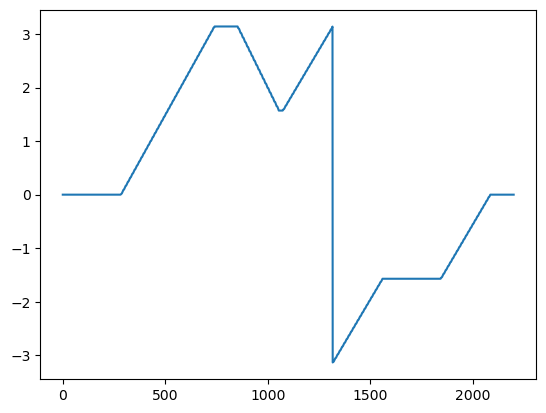

/opt/anaconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
2025-05-13 11:41:09.526 | DEBUG    | gym_carla.envs.barc.barc_env:reset:181 - Respawning at fixed location.


self.m is  2
=================== new iteration ===================


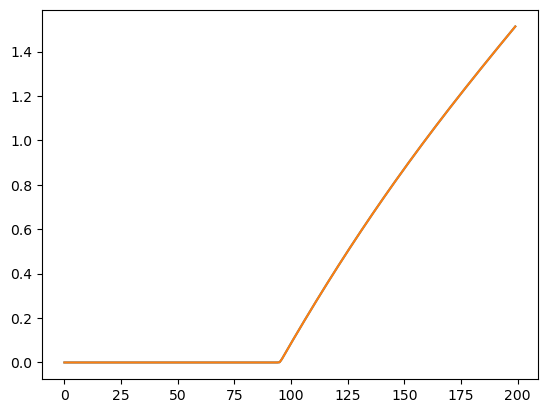

initial state is [0.1 0.  0.  0.5]
first reference goal state is [ 0.105      -0.14945618  0.          4.56865167]
end of horizon goal state is [3.2532941  1.09460132 1.51309429 2.84883873]
optimal input is [-0.04821773  1.99999969]
end of horizon predicted state is [3.19755776 1.51276656 1.79539292 2.64119968]


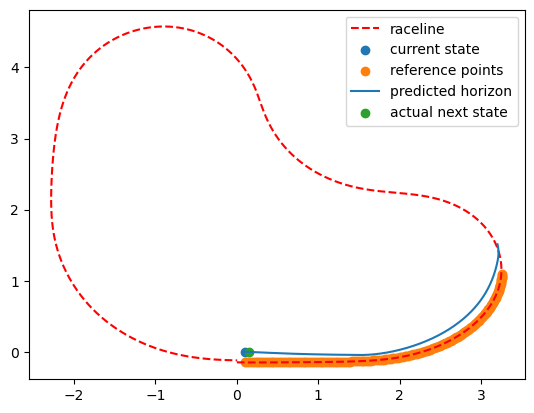

=================== new iteration ===================


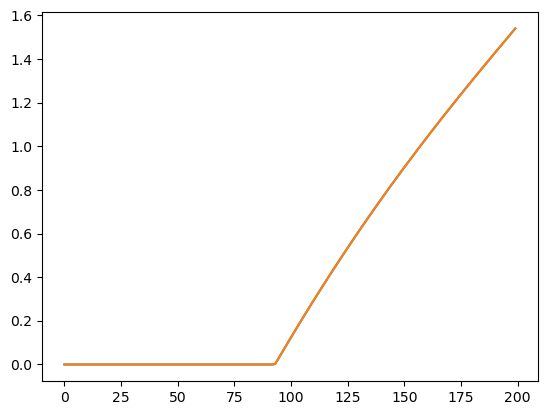

initial state is [0.15 0.   0.   0.5 ]
first reference goal state is [ 0.155      -0.14979594  0.          4.57580734]
end of horizon goal state is [3.2545045  1.12170709 1.54012058 2.84321199]
optimal input is [-0.04718789  1.99999969]
end of horizon predicted state is [3.17557371 1.53688415 1.81662724 2.60825582]


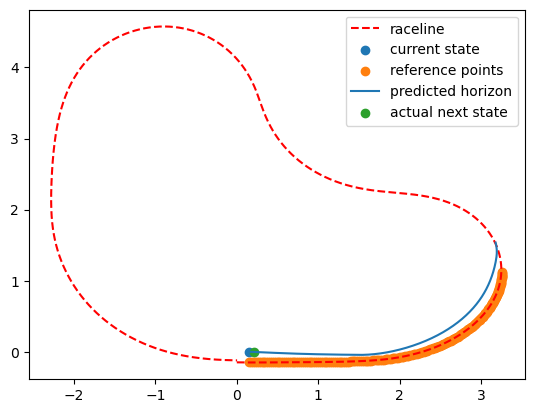

=================== new iteration ===================


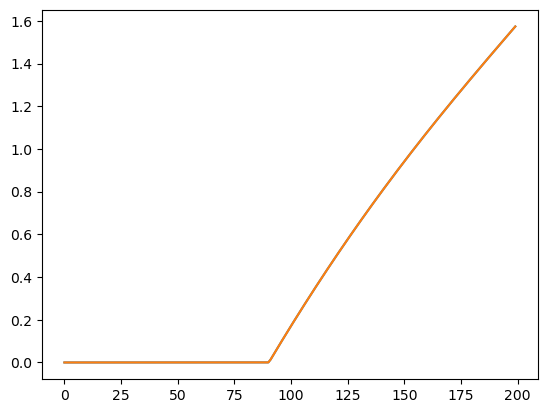

initial state is [ 0.20993452 -0.00165647 -0.0106212   0.69930824]
first reference goal state is [ 0.2169276  -0.14995821  0.          4.58437792]
end of horizon goal state is [3.25495991 1.15517943 1.57346517 2.83742866]
optimal input is [-0.0157496   1.99999941]
end of horizon predicted state is [3.35761446 1.56353706 1.84346169 2.5656048 ]


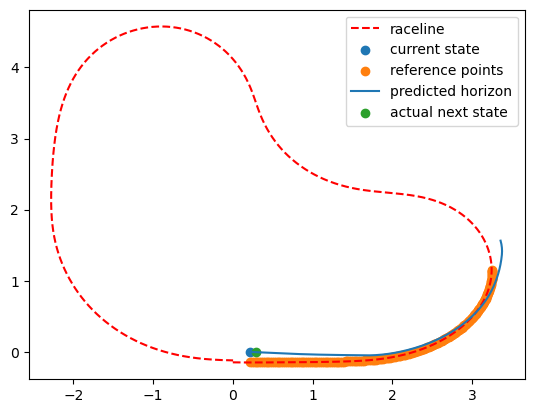

=================== new iteration ===================


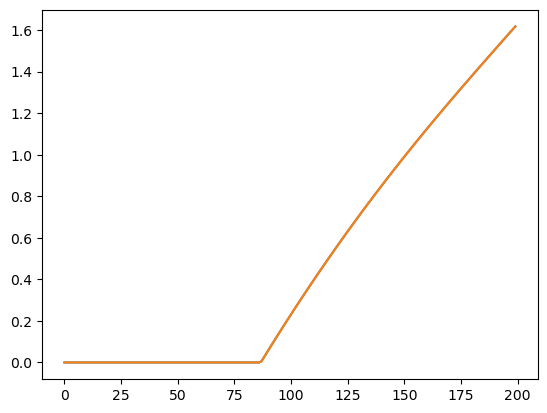

initial state is [ 0.28981201 -0.00488016 -0.02494286  0.89913438]
first reference goal state is [ 0.29880336 -0.14984813  0.          4.59490444]
end of horizon goal state is [3.2538311  1.1992367  1.6173674  2.83232381]
optimal input is [-9.16229019e-04  1.99999927e+00]
end of horizon predicted state is [3.50838143 1.59919075 1.87953895 2.52045519]


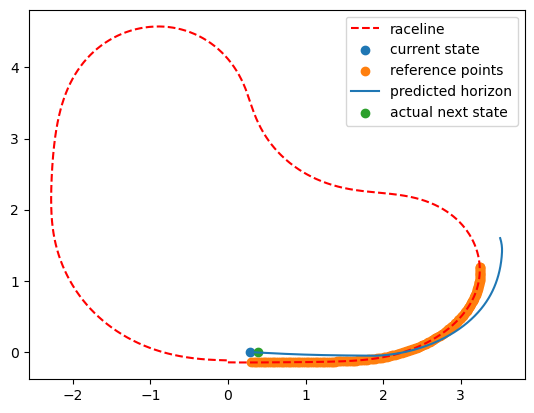

=================== new iteration ===================


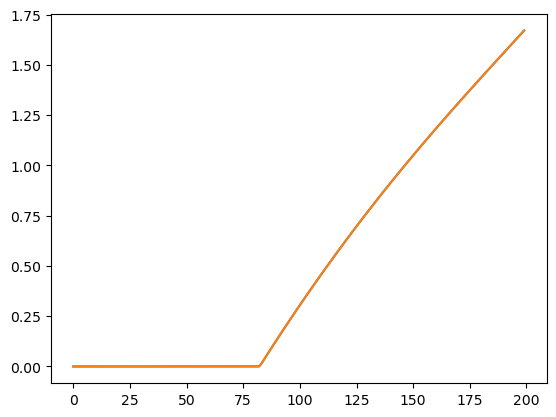

initial state is [ 0.38967754 -0.00858403 -0.03162315  1.09930835]
first reference goal state is [ 0.40067062 -0.14937544  0.          4.60626663]
end of horizon goal state is [3.24971531 1.25368457 1.67176654 2.82921808]
optimal input is [0.00604607 1.99999908]
end of horizon predicted state is [3.62521143 1.64398888 1.92521123 2.47669053]


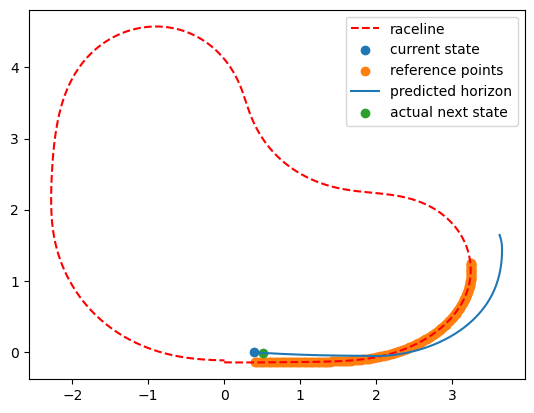

=================== new iteration ===================


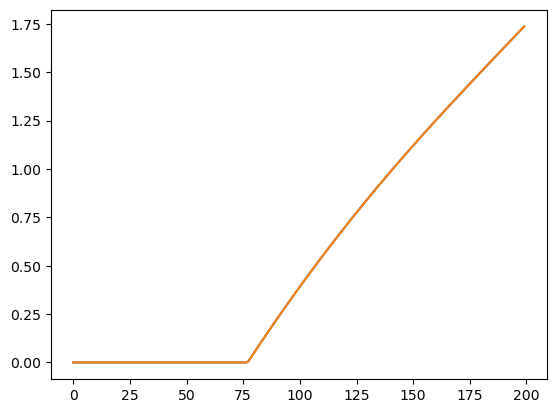

initial state is [ 0.50954256 -0.01258231 -0.0325384   1.29931658]
first reference goal state is [ 0.52253573 -0.148557    0.          4.61666742]
end of horizon goal state is [3.24090676 1.31820292 1.73665109 2.8301974 ]
optimal input is [0.01013418 1.99999879]
end of horizon predicted state is [3.70578685 1.6981621  1.98075872 2.43915841]


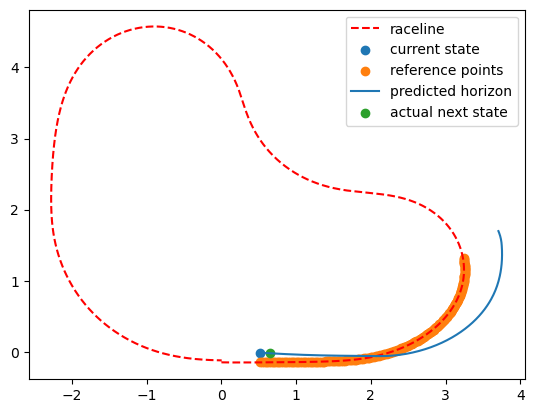

=================== new iteration ===================


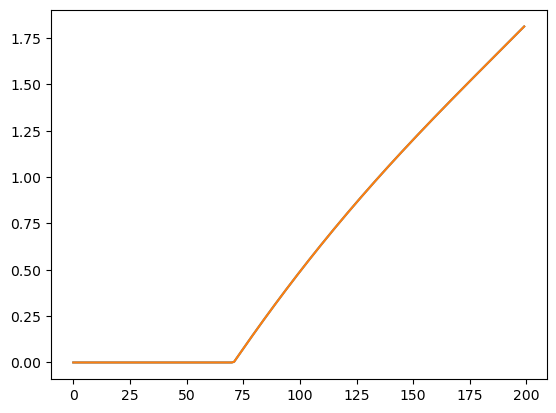

initial state is [ 0.64941358 -0.01663473 -0.02965785  1.49928985]
first reference goal state is [ 0.66440648 -0.14748154  0.          4.6237901 ]
end of horizon goal state is [3.22539996 1.39232378 1.81212423 2.83699891]
optimal input is [0.01276884 1.99999836]
end of horizon predicted state is [3.74875208 1.76189565 2.04637961 2.41208302]


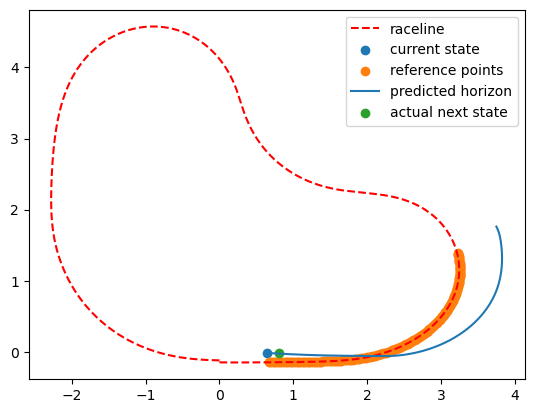

=================== new iteration ===================


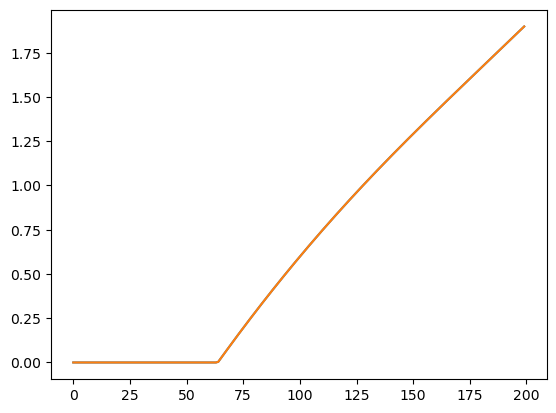

initial state is [ 0.8092987  -0.02029319 -0.02376979  1.69924918]
first reference goal state is [ 0.82629119 -0.14617328  0.          4.62446125]
end of horizon goal state is [3.20086431 1.47537334 1.89845885 2.85094845]
optimal input is [0.0145332  1.99999848]
end of horizon predicted state is [3.75387805 1.83510926 2.12319361 2.39810423]


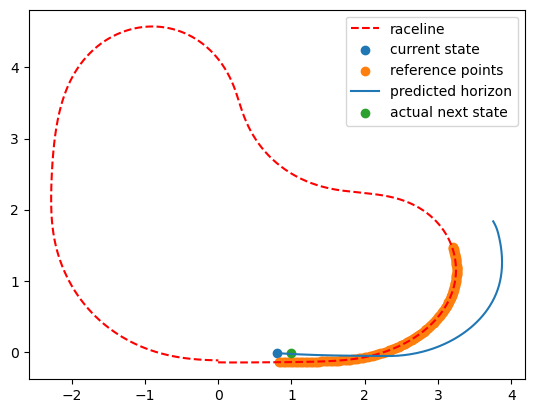

=================== new iteration ===================


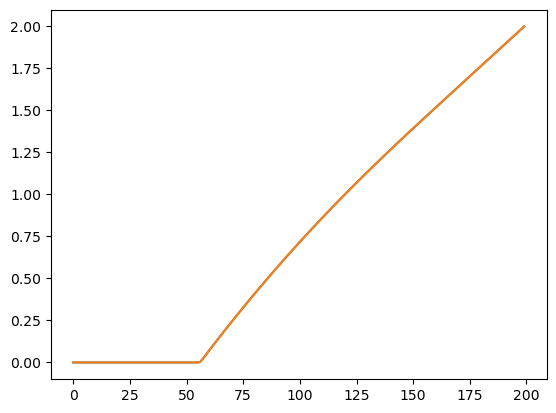

initial state is [ 0.98920182 -0.02296018 -0.01527362  1.8991946 ]
first reference goal state is [ 1.00819376 -0.1443528   0.          4.61499487]
end of horizon goal state is [3.16460071 1.56635771 1.99613918 2.8726994 ]
optimal input is [0.01567966 1.9999965 ]
end of horizon predicted state is [3.71882013 1.91716473 2.21148084 2.39930285]


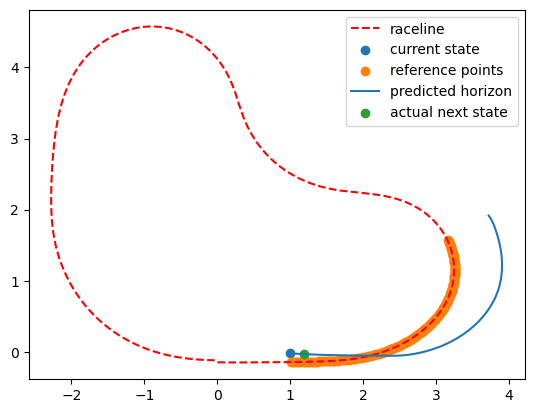

=================== new iteration ===================


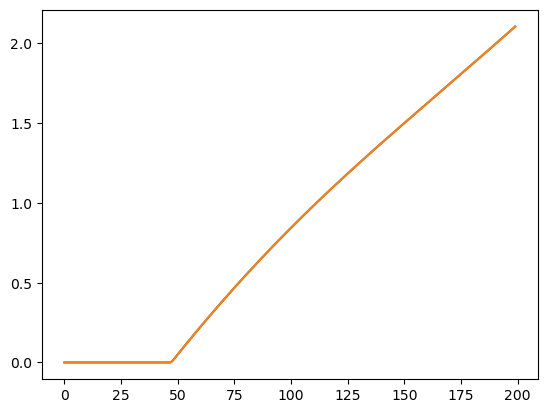

initial state is [ 1.18911636 -0.02392119 -0.00443951  2.09912087]
first reference goal state is [ 1.21010757 -0.14116454  0.          4.59107513]
end of horizon goal state is [3.11357869 1.66382177 2.10589215 2.90163068]
optimal input is [0.01619987 1.99999428]
end of horizon predicted state is [3.63976771 2.00653863 2.31093222 2.41699873]


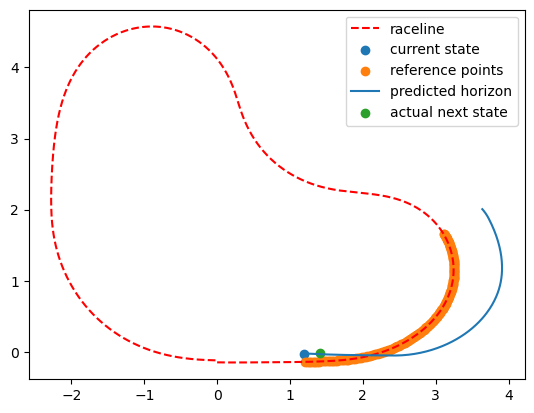

=================== new iteration ===================


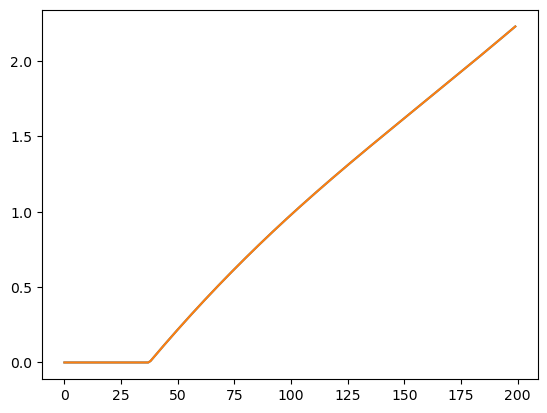

initial state is [ 1.40901904 -0.022367    0.00848608  2.29902063]
first reference goal state is [ 1.43200924 -0.13484275  0.          4.54789908]
end of horizon goal state is [3.04440485 1.76562085 2.22871276 2.9367645 ]
optimal input is [0.01561662 1.99998935]
end of horizon predicted state is [3.51217768 2.10033832 2.4231839  2.45197513]


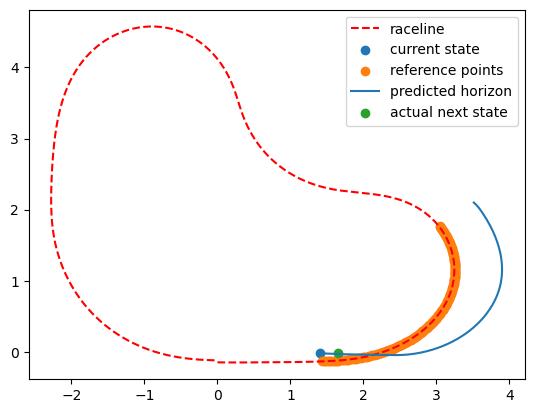

=================== new iteration ===================


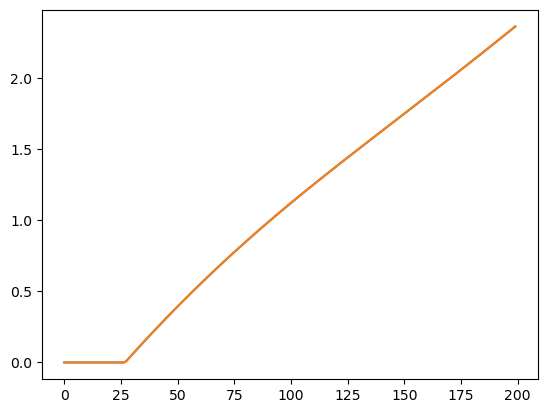

initial state is [ 1.64886467 -0.01743693  0.02313409  2.49888981]
first reference goal state is [ 1.67385357 -0.12128467  0.          4.47468796]
end of horizon goal state is [2.95340569 1.86875755 2.36595821 2.97650719]
optimal input is [0.01214519 1.99997384]
end of horizon predicted state is [3.3290612  2.19427689 2.54711089 2.50706342]


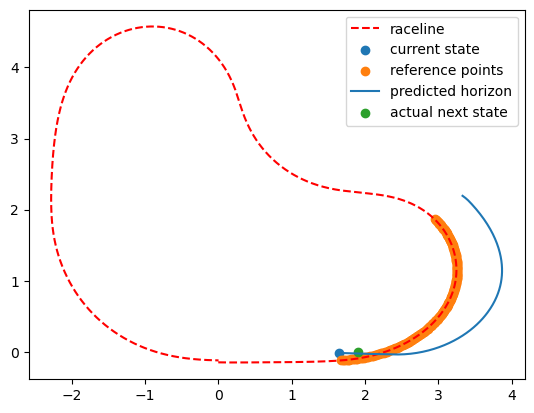

=================== new iteration ===================


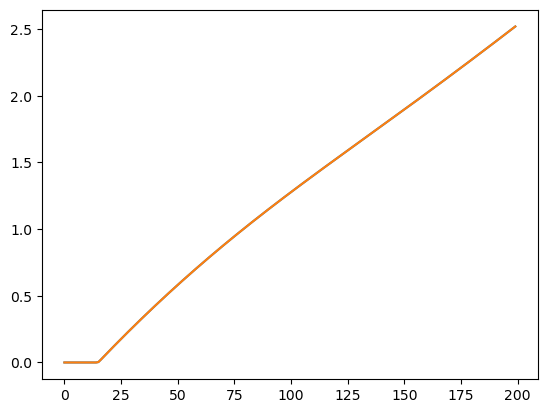

initial state is [ 1.90858771 -0.00834791  0.03860894  2.69874241]
first reference goal state is [ 1.93557514 -0.08913032  0.          4.33621118]
end of horizon goal state is [2.83608883 1.96944485 2.52008241 3.02205115]
optimal input is [0.00279221 1.99970397]
end of horizon predicted state is [3.07859833 2.28204591 2.68490512 2.58616022]


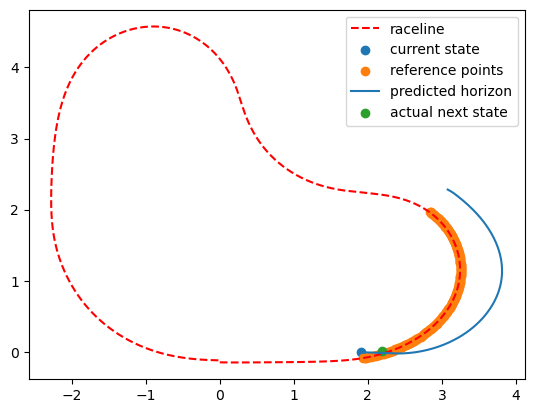

=================== new iteration ===================


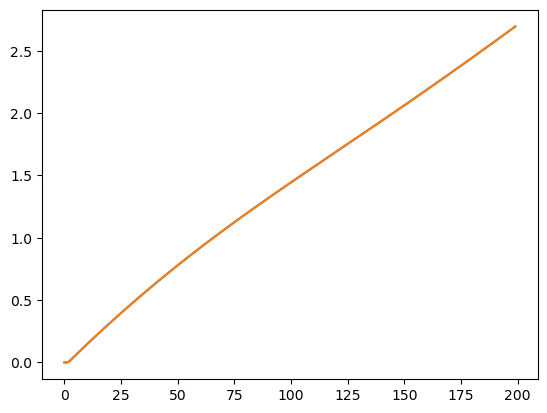

initial state is [2.18813092 0.00517759 0.05217954 2.89864773]
first reference goal state is [ 2.2171174  -0.02211448  0.          4.13332082]
end of horizon goal state is [2.68644834 2.0628604  2.69543374 3.07924617]
optimal input is [ 0.15747829 -1.99988944]
end of horizon predicted state is [2.7408621  2.35374508 2.83953486 2.69771994]


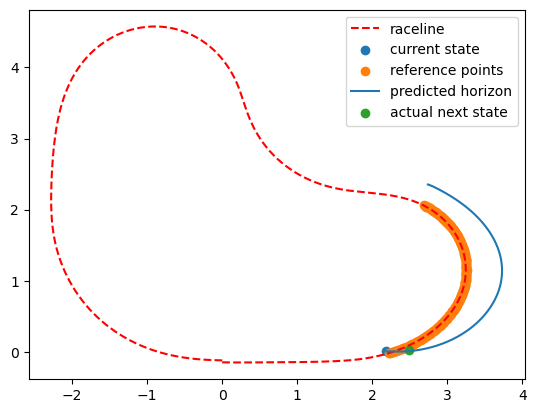

=================== new iteration ===================


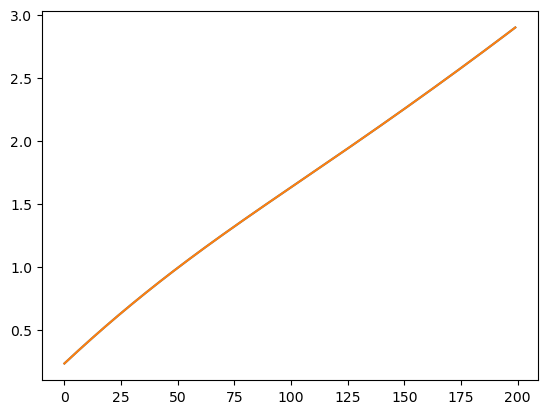

initial state is [2.48752641 0.02194294 0.05750823 3.09862802]
first reference goal state is [2.50280409 0.09199864 0.23312376 3.8760202 ]
end of horizon goal state is [2.49578092 2.1427146  2.89925091 3.16066642]
[MPC] Solver failed: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1336: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'
  X0: [2.48752641 0.02194294 0.05750823 3.09862802]
optimal input is [0. 0.]
end of horizon predicted state is [2.48752641 0.02194294 0.05750823 3.09862802]


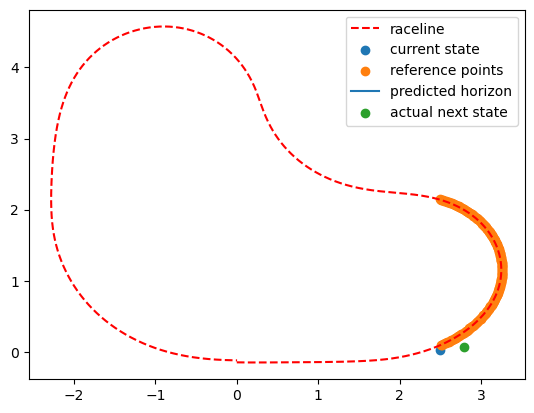

=================== new iteration ===================


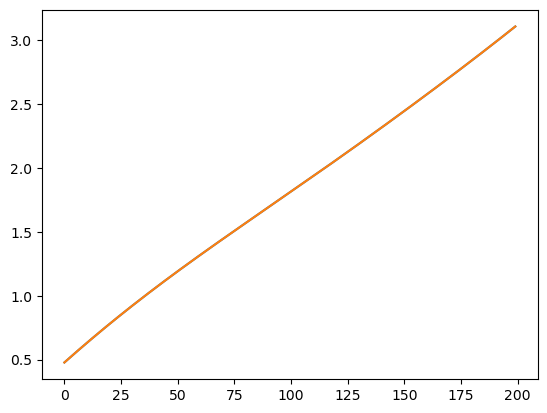

initial state is [2.7823312  0.0608467  0.18426808 2.86032145]
first reference goal state is [2.72964078 0.22812536 0.47778695 3.63266748]
end of horizon goal state is [2.28613181 2.19541654 3.1079168  3.26649348]
optimal input is [ 0.14217833 -1.99999921]
end of horizon predicted state is [2.13690026 2.38329661 3.19186828 2.95834114]


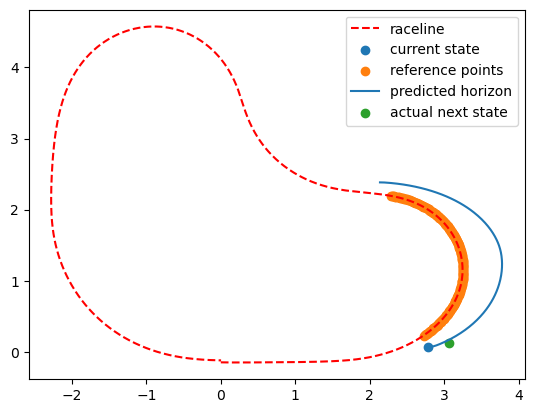

=================== new iteration ===================


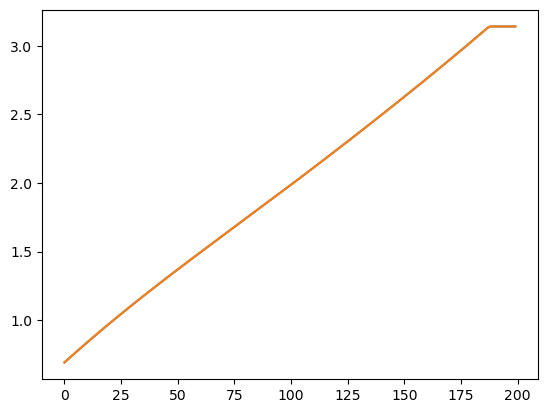

initial state is [3.0620148  0.1210866  0.22172825 2.86087915]
first reference goal state is [2.89907649 0.36912924 0.69116317 3.42298858]
end of horizon goal state is [2.05845081 2.22700737 3.14159265 3.39592498]
optimal input is [ 0.25427593 -1.99999905]
end of horizon predicted state is [1.85579391 2.35301025 3.25956191 2.99999475]


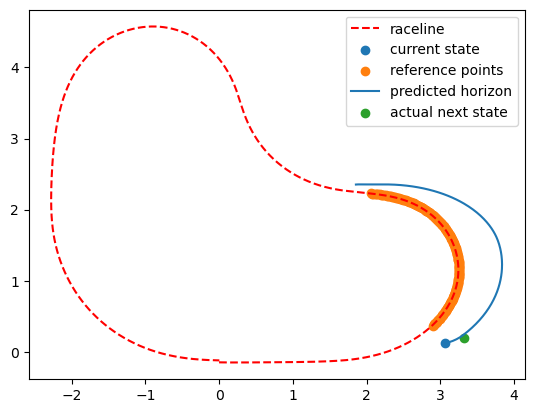

=================== new iteration ===================


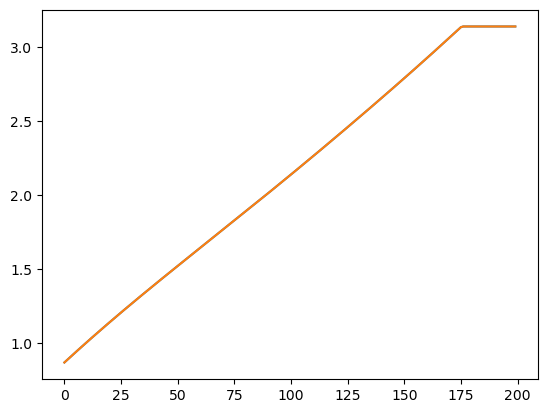

initial state is [3.32458105 0.19979664 0.33239424 2.63199325]
first reference goal state is [3.01895634 0.50174077 0.86781965 3.25620546]
end of horizon goal state is [1.84849036 2.24810731 3.14159265 3.5106425 ]
optimal input is [ 0.39999954 -1.99999533]
end of horizon predicted state is [1.37896112 2.32091813 3.28997536 2.99999584]


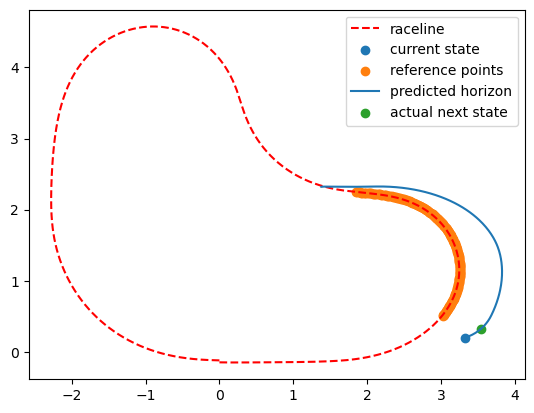

=================== new iteration ===================


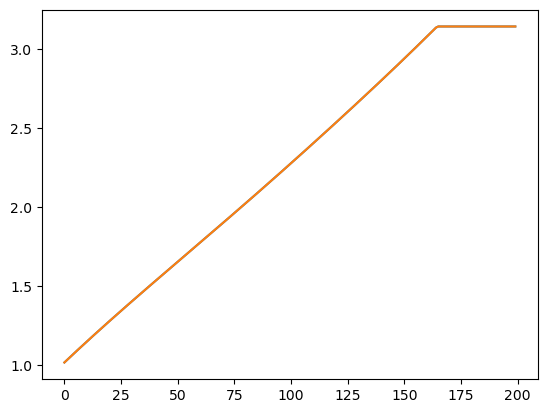

initial state is [3.54576109 0.31514378 0.54324846 2.37220954]
first reference goal state is [3.10438603 0.62518077 1.01730899 3.1255355 ]
end of horizon goal state is [1.65704616 2.27246845 3.14159265 3.59410265]
optimal input is [ 0.39999947 -1.99997509]
end of horizon predicted state is [1.08255489 2.31129117 3.30749613 2.99999635]


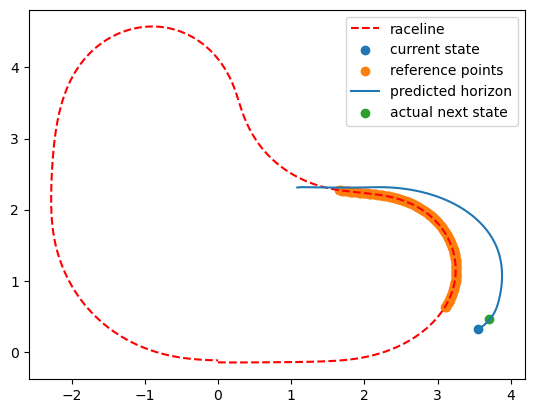

=================== new iteration ===================


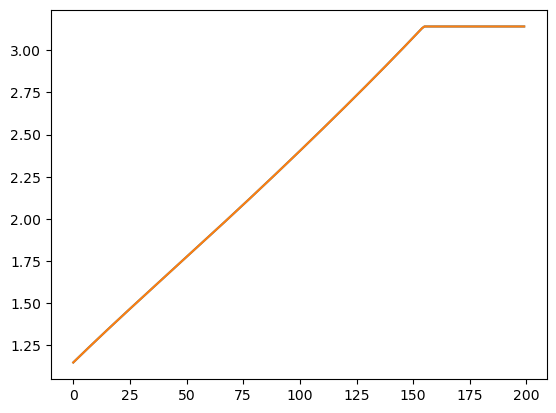

initial state is [3.70683342 0.46689183 0.8190453  2.06431501]
first reference goal state is [3.16556727 0.74164416 1.14857856 3.02422025]
end of horizon goal state is [1.47922276 2.30784386 3.14159265 3.64282756]
optimal input is [ 0.39999816 -1.99982681]
end of horizon predicted state is [0.80969684 2.31174371 3.31769102 2.99999658]


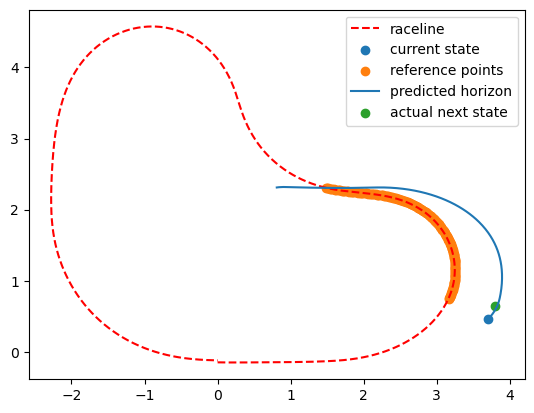

=================== new iteration ===================


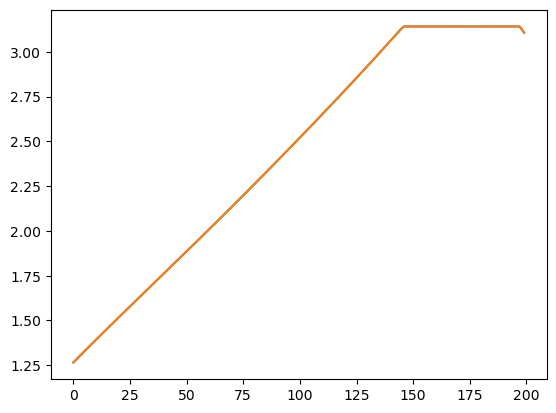

initial state is [3.79638303 0.63884157 1.12091225 1.8093225 ]
first reference goal state is [3.20770053 0.85110299 1.26560079 2.94886949]
end of horizon goal state is [1.31612569 2.35592231 3.1066571  3.66449534]
optimal input is [ 0.1870213  -1.30103772]
end of horizon predicted state is [0.54684132 2.32203816 3.30948203 2.99999832]


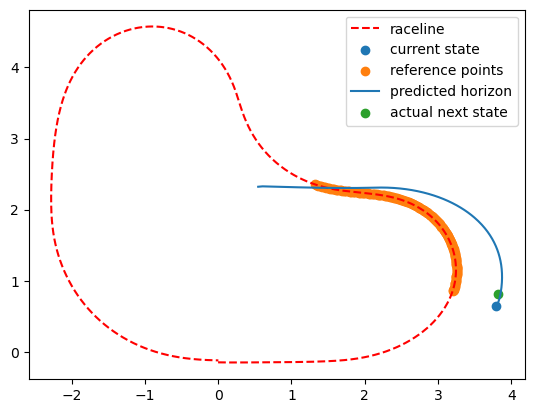

=================== new iteration ===================


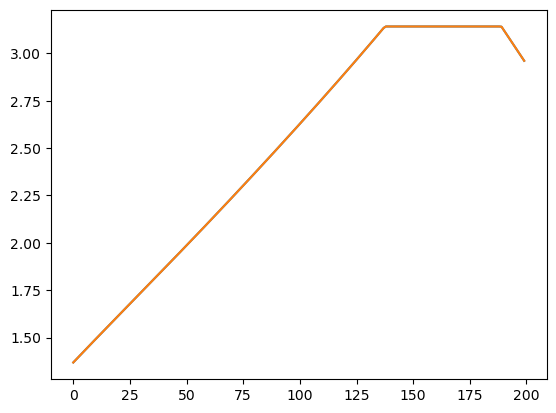

initial state is [3.82455126 0.8073691  1.39332143 1.58625995]
first reference goal state is [3.23416218 0.95100169 1.36864646 2.89686548]
end of horizon goal state is [1.18233518 2.40858916 2.96066233 3.67088654]
optimal input is [ 0.19241213 -0.83511043]
end of horizon predicted state is [0.31367393 2.36081467 3.200839   2.99999834]


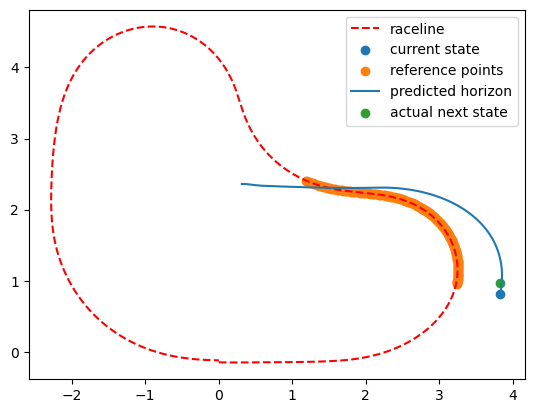

=================== new iteration ===================


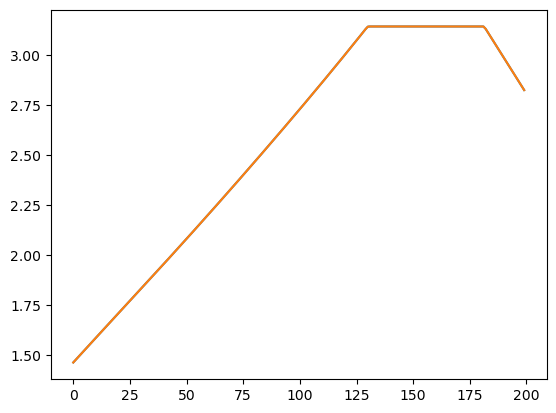

initial state is [3.82676037 0.96238864 1.52629007 1.4824094 ]
first reference goal state is [3.24914152 1.04508292 1.46359181 2.86206391]
end of horizon goal state is [1.06736602 2.46544886 2.82397097 3.67034563]
optimal input is [ 0.21740315 -0.73434411]
end of horizon predicted state is [0.11216716 2.42809425 3.09137452 2.9999967 ]


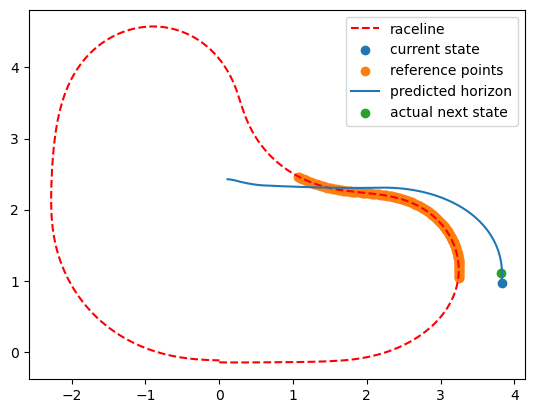

=================== new iteration ===================


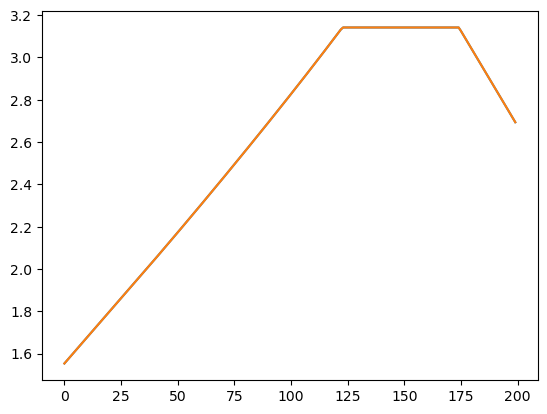

initial state is [3.81382502 1.10612557 1.6340028  1.39667269]
first reference goal state is [3.25482554 1.13488494 1.55325021 2.84075545]
end of horizon goal state is [0.96595651 2.52588551 2.69367531 3.66582101]
optimal input is [ 0.24194084 -0.60762608]
end of horizon predicted state is [-0.06534496  2.51557757  2.98752745  2.99999668]


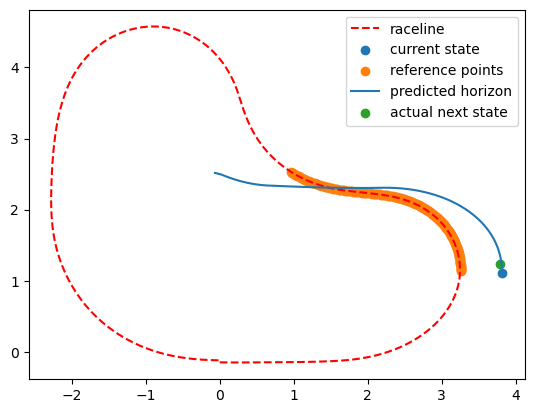

=================== new iteration ===================


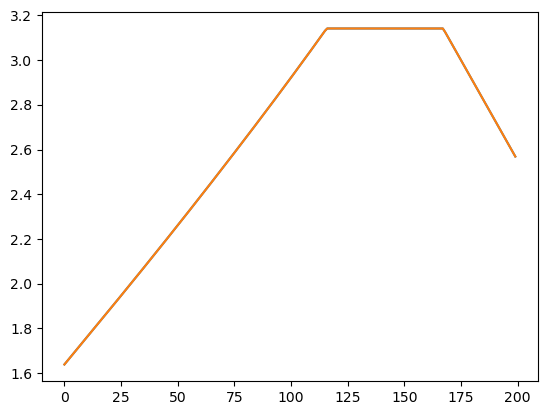

initial state is [3.78522233 1.23921244 1.74776016 1.31854389]
first reference goal state is [3.25257446 1.22061109 1.63869581 2.83062447]
end of horizon goal state is [0.87553523 2.5891766  2.56897862 3.65893795]
optimal input is [ 0.26375003 -0.61117851]
end of horizon predicted state is [-0.22179789  2.61726956  2.88824685  2.99999665]


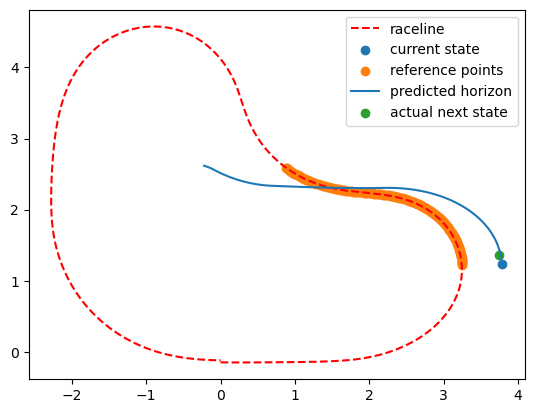

=================== new iteration ===================


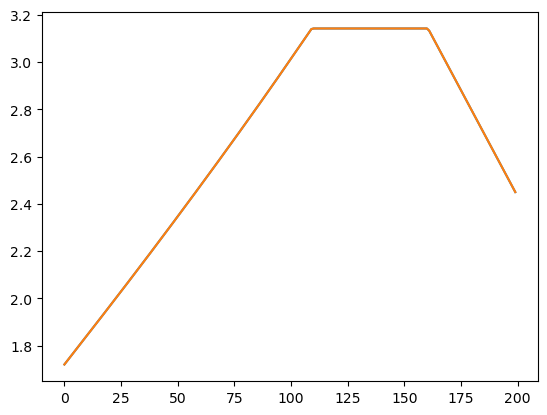

initial state is [3.74198585 1.36081802 1.86817138 1.25299448]
first reference goal state is [3.24348236 1.30218592 1.72048795 2.82953903]
end of horizon goal state is [0.79446259 2.65477673 2.44960787 3.65023325]
optimal input is [ 0.27706568 -0.83964433]
end of horizon predicted state is [-0.35897424  2.7285088   2.79023909  2.99999661]


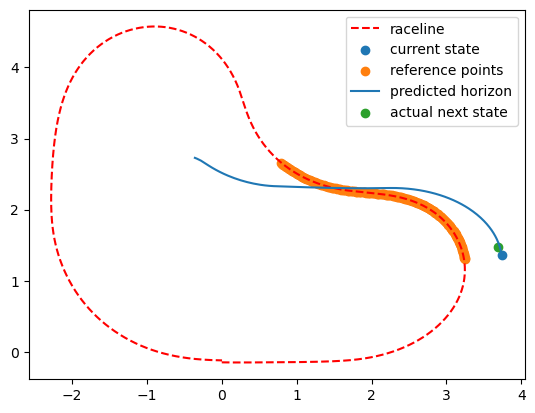

=================== new iteration ===================


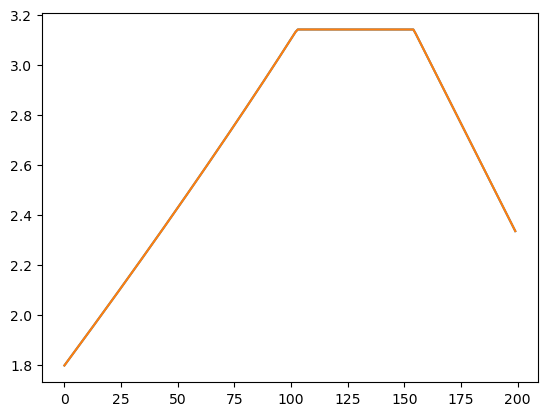

initial state is [3.68574947 1.46981473 1.9934616  1.18765134]
first reference goal state is [3.22854459 1.37928832 1.79876149 2.83542277]
end of horizon goal state is [0.7217128  2.72207708 2.33573508 3.64089453]
optimal input is [ 0.27634128 -0.78968724]
end of horizon predicted state is [-0.47794242  2.84539889  2.69672552  2.99999657]


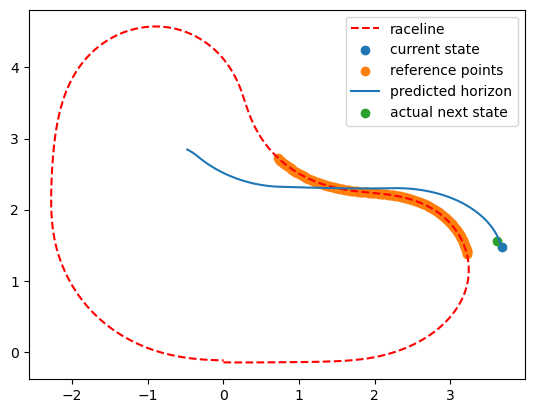

=================== new iteration ===================


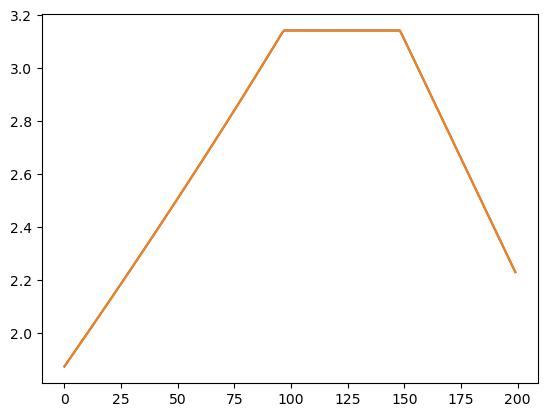

initial state is [3.6197515  1.564251   2.11795967 1.10182198]
first reference goal state is [3.20896073 1.45069213 1.87256765 2.84619264]
end of horizon goal state is [0.65733993 2.78965552 2.22893503 3.63191745]
optimal input is [0.22386814 0.17737321]
end of horizon predicted state is [-0.58123595  2.96325265  2.60893881  2.99999653]


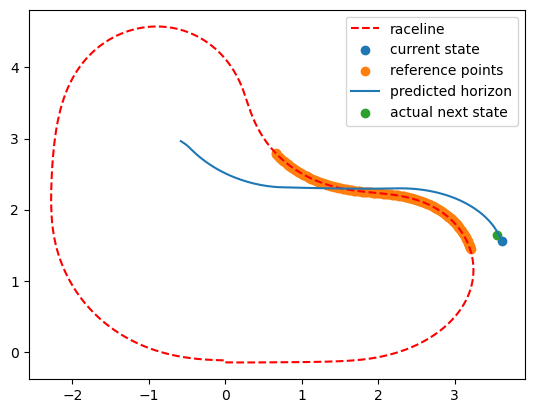

=================== new iteration ===================


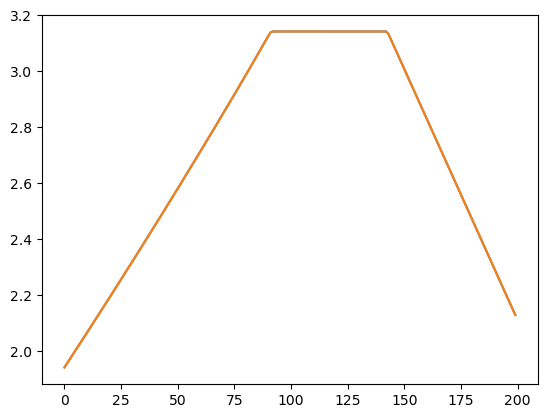

initial state is [3.54810139 1.6438284  2.23396889 1.02355045]
first reference goal state is [3.18587882 1.51614865 1.94176629 2.85995335]
end of horizon goal state is [0.60062576 2.85674057 2.12946345 3.62355473]
optimal input is [0.06991851 0.94911487]
end of horizon predicted state is [-0.67019482  3.07928513  2.52700711  2.99999649]


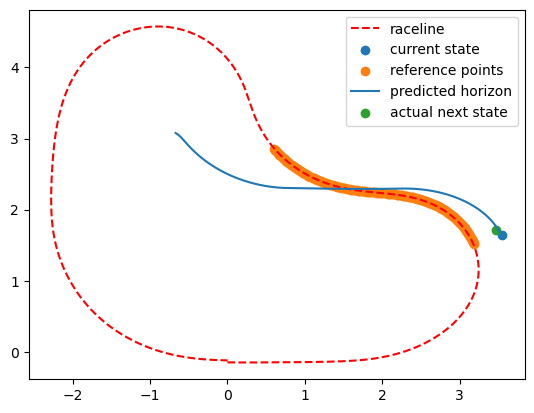

=================== new iteration ===================


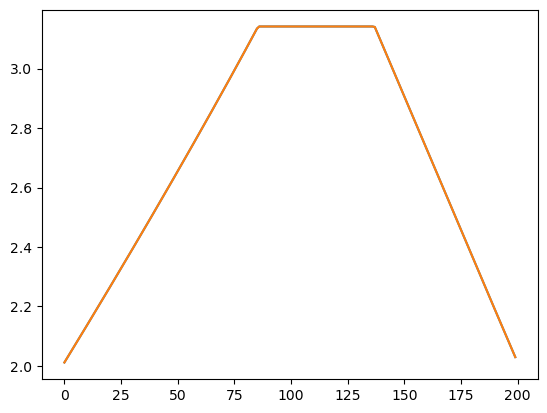

initial state is [3.47214787 1.71522369 2.32614751 1.04554651]
first reference goal state is [3.15801634 1.58048488 2.0116798  2.87655457]
end of horizon goal state is [0.54687317 2.92834041 2.0297164  3.61548187]
optimal input is [-0.01164814  1.02859837]
end of horizon predicted state is [-0.74711026  3.20096363  2.44384652  2.99999818]


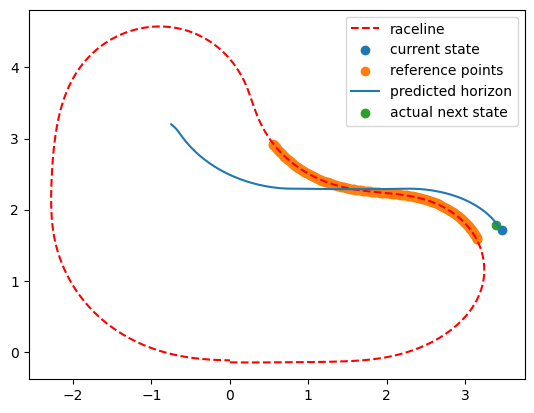

=================== new iteration ===================


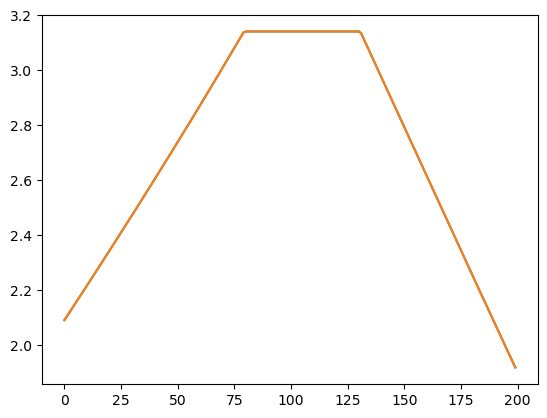

initial state is [3.39219083 1.79054586 2.36141453 1.14538994]
first reference goal state is [3.12133791 1.6505279  2.0905416  2.89743583]
end of horizon goal state is [0.49051368 3.01397877 1.91818034 3.6074173 ]
optimal input is [0.20422619 1.27148412]
end of horizon predicted state is [-0.77686008  3.33032373  2.34835676  2.99999641]


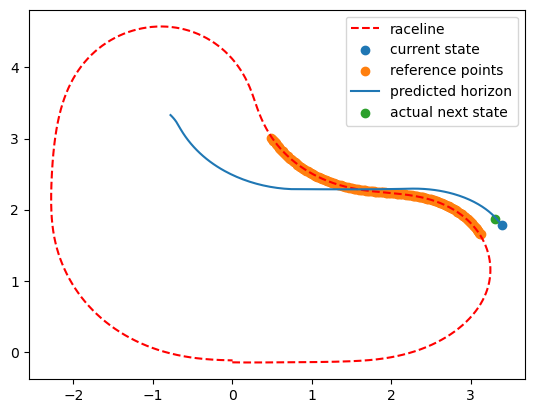

=================== new iteration ===================


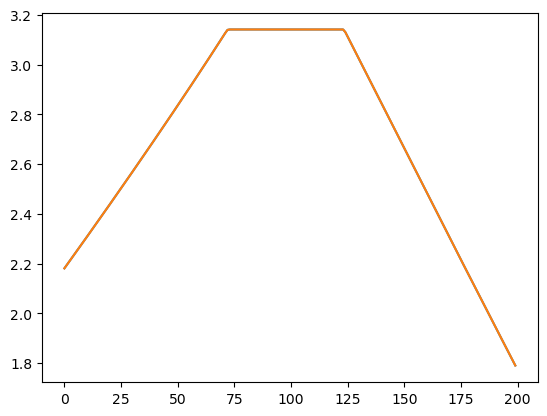

initial state is [3.30723558 1.87479494 2.35926458 1.24785205]
first reference goal state is [3.07248855 1.72741764 2.1814207  2.92304726]
end of horizon goal state is [0.43117003 3.11956325 1.79094698 3.60070728]
optimal input is [0.27760014 0.99976906]
end of horizon predicted state is [-0.75894134  3.46857217  2.23850907  2.99999638]


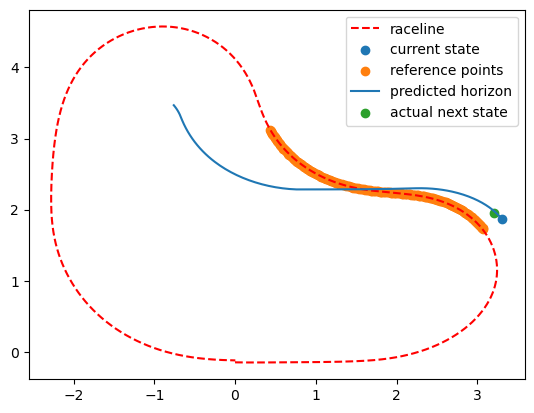

=================== new iteration ===================


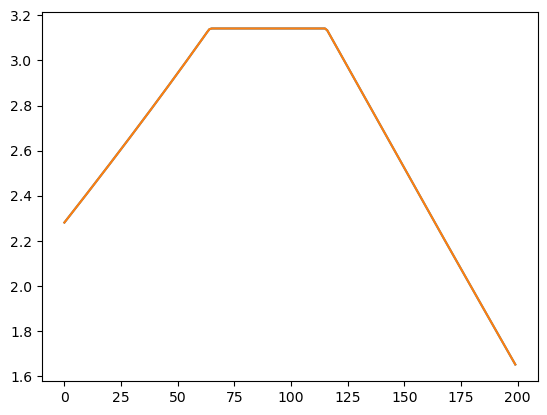

initial state is [3.20594153 1.95516714 2.44524028 1.34862045]
first reference goal state is [3.01104809 1.80668024 2.28147473 2.95197144]
end of horizon goal state is [0.37267928 3.24527556 1.65236209 3.59888189]
optimal input is [0.25965842 0.98132028]
end of horizon predicted state is [-0.72425877  3.61483744  2.1179775   2.99999637]


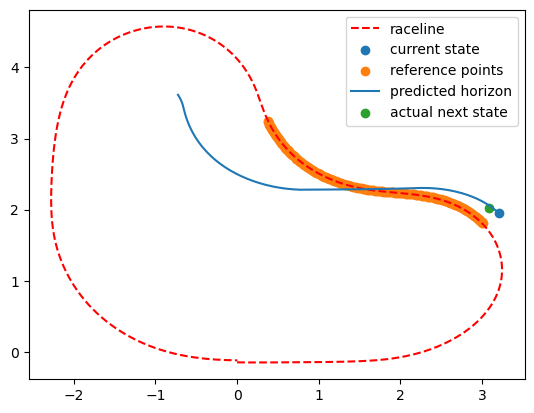

=================== new iteration ===================


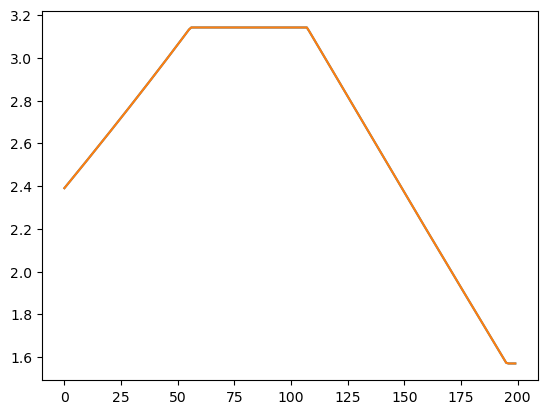

initial state is [3.08438189 2.02314086 2.5898595  1.42983668]
first reference goal state is [2.93575265 1.88586843 2.39046269 2.98365559]
end of horizon goal state is [0.3169845  3.3944845  1.57079633 3.60650753]
optimal input is [0.23742656 1.3671589 ]
end of horizon predicted state is [-0.67277153  3.77064607  2.00509339  2.99997653]


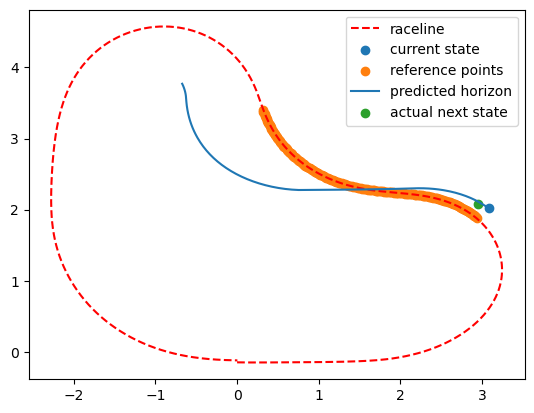

=================== new iteration ===================


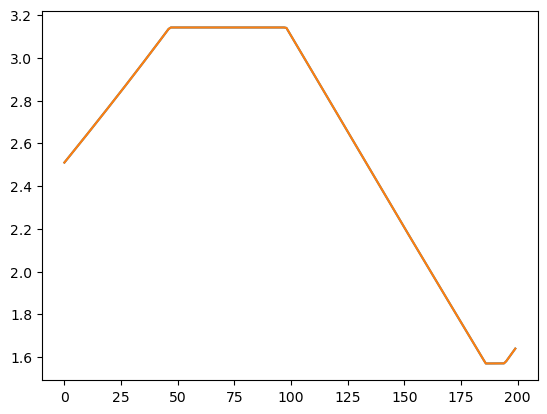

initial state is [2.9456007  2.07625855 2.73972034 1.52402828]
first reference goal state is [2.8441363  1.96342584 2.5100819  3.0189629 ]
end of horizon goal state is [0.26575202 3.55611146 1.64022347 3.61117588]
optimal input is [0.20734616 1.34161747]
end of horizon predicted state is [-0.62279094  3.92115197  2.01130885  2.93779887]


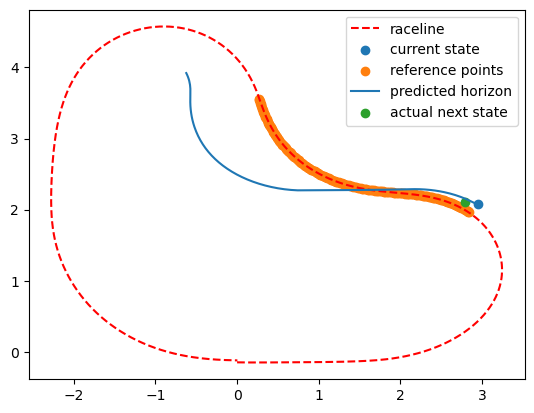

=================== new iteration ===================


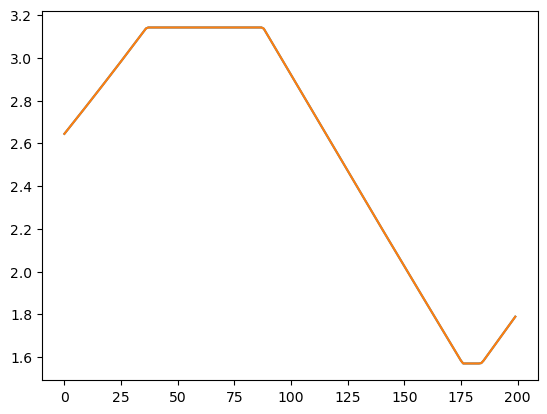

initial state is [2.78995289 2.11256377 2.88689243 1.65667514]
first reference goal state is [2.73152598 2.0380716  2.64443513 3.0615598 ]
end of horizon goal state is [0.20821502 3.72118484 1.78956405 3.57414777]
optimal input is [0.18181533 1.50110823]
end of horizon predicted state is [-0.60808642  4.07529855  2.13190848  2.88555629]


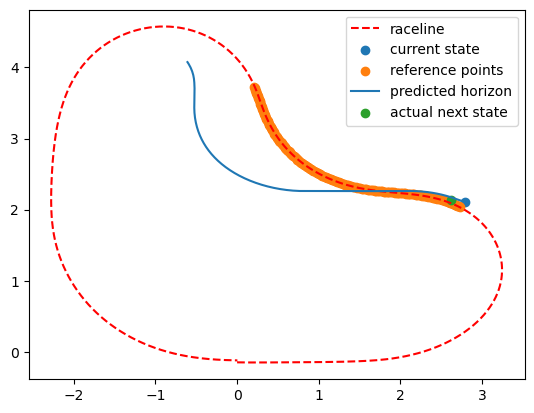

=================== new iteration ===================


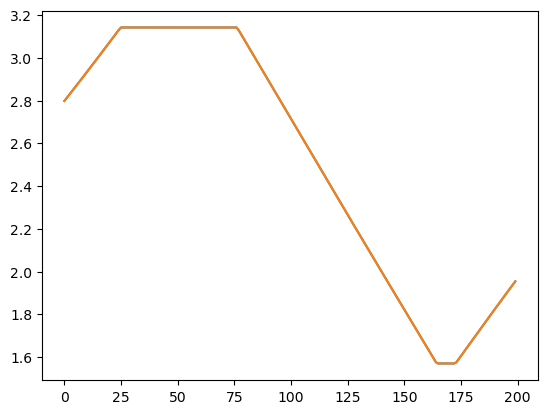

initial state is [2.6179417  2.12997998 3.02657279 1.78814895]
first reference goal state is [2.59245546 2.10683314 2.79799058 3.11766384]
end of horizon goal state is [0.13046585 3.89101226 1.95491631 3.49961594]
optimal input is [0.17130982 1.99941357]
end of horizon predicted state is [-0.63778924  4.23346579  2.27801693  2.83809171]


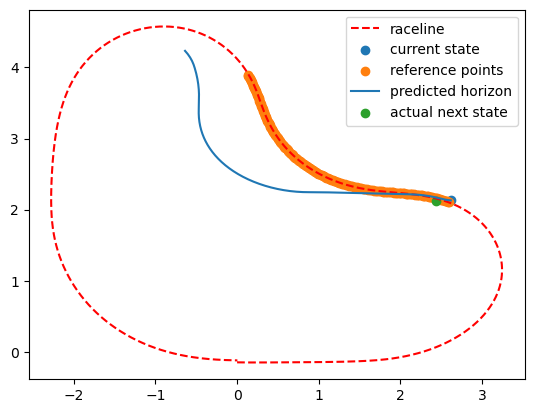

=================== new iteration ===================


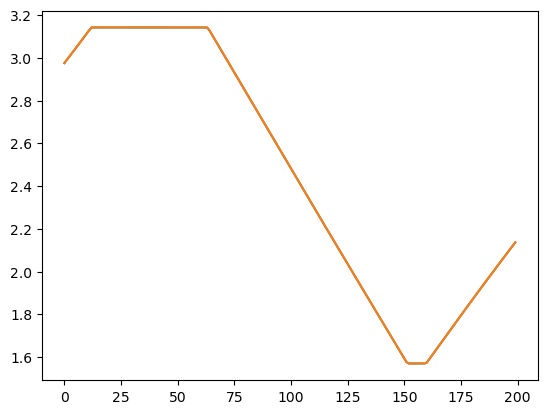

initial state is [2.43136953 2.12603243 3.15850912 1.93475544]
first reference goal state is [2.42105876 2.16498658 2.97518414 3.19638564]
end of horizon goal state is [0.02414302 4.06165565 2.13710012 3.3988874 ]
optimal input is [0.16974465 1.99900064]
end of horizon predicted state is [-0.71959129  4.38592059  2.4341403   2.7759968 ]


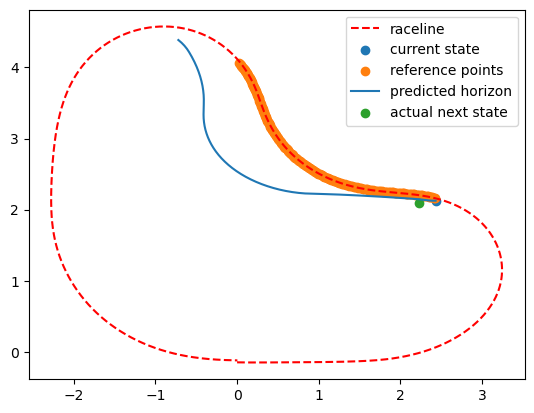

=================== new iteration ===================


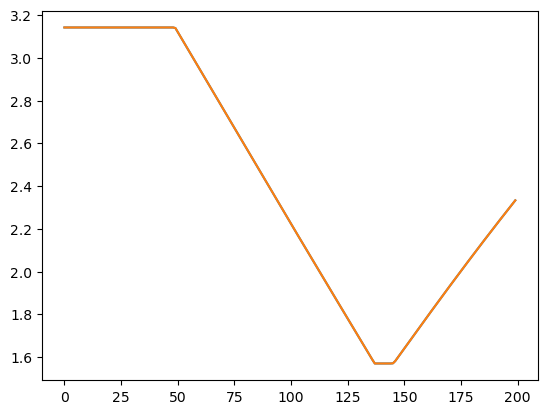

initial state is [2.23006435 2.09667856 3.29214025 2.12780967]
first reference goal state is [2.20878625 2.20831871 3.14159265 3.30960845]
end of horizon goal state is [-0.11502381  4.22354266  2.33338074  3.28171952]
optimal input is [-0.00233704  1.99985675]
end of horizon predicted state is [-0.84061905  4.51992726  2.59519551  2.7052136 ]


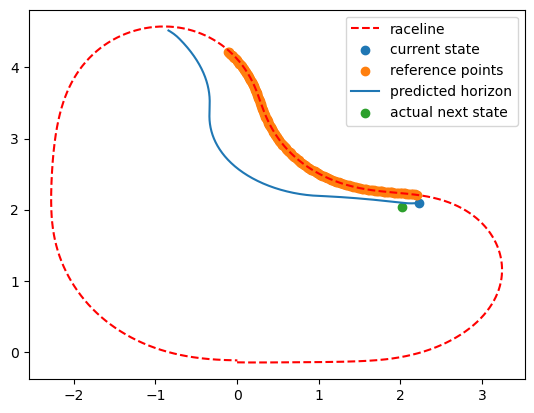

=================== new iteration ===================


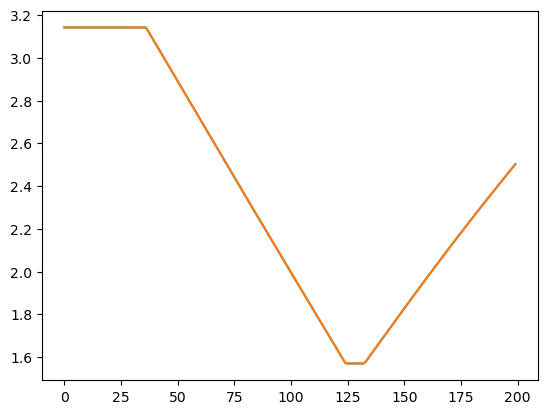

initial state is [2.01609708 2.03588768 3.43565968 2.31714529]
first reference goal state is [1.99292562 2.23371304 3.14159265 3.43321856]
end of horizon goal state is [-0.25432085  4.3415845   2.50237764  3.18707127]
optimal input is [-0.39999625  1.99994121]
end of horizon predicted state is [-1.00262444  4.61128069  2.72991766  2.6790112 ]


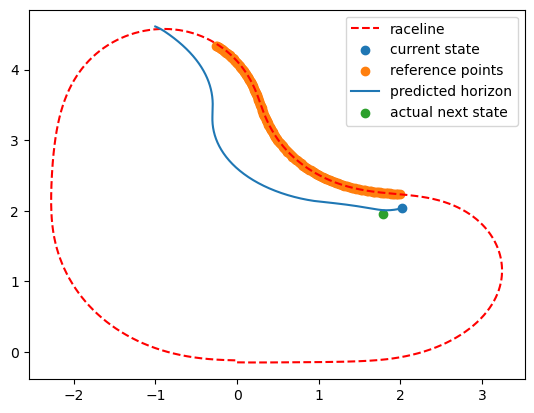

=================== new iteration ===================


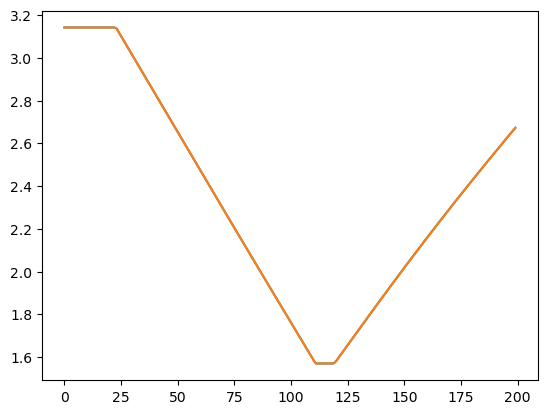

initial state is [1.78677918 1.95901629 3.46266458 2.51846717]
first reference goal state is [1.7615945  2.2579362  3.14159265 3.55193004]
end of horizon goal state is [-0.4107118   4.43697188  2.67235796  3.11082911]
optimal input is [-0.39999837  1.99995529]
end of horizon predicted state is [-1.19413867  4.67810207  2.86079131  2.69543349]


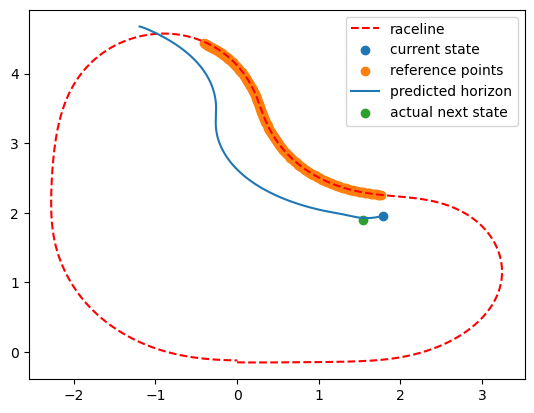

=================== new iteration ===================


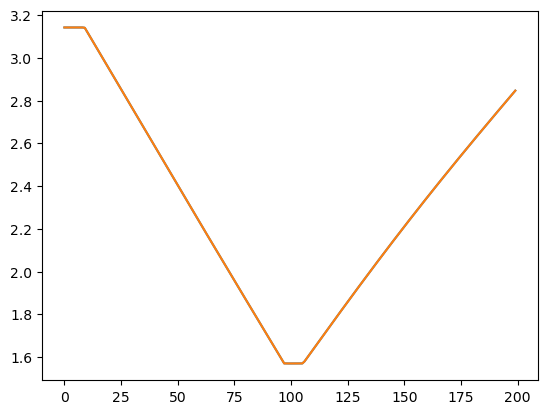

initial state is [1.53863796 1.89798867 3.34279322 2.5910351 ]
first reference goal state is [1.51272761 2.29992743 3.14159265 3.63587348]
end of horizon goal state is [-0.58448519  4.50681426  2.84625352  3.06261636]
optimal input is [-0.39999158  1.99998491]
end of horizon predicted state is [-1.37269502  4.71564059  2.98084495  2.75539155]


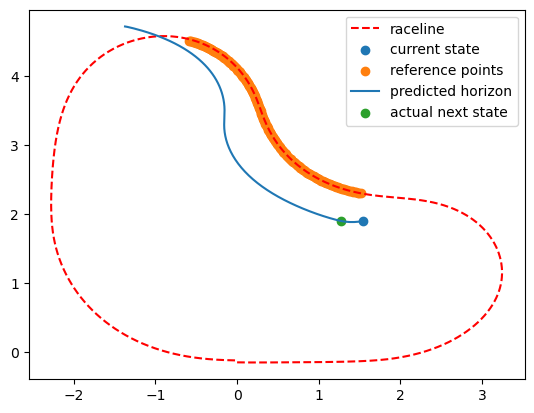

=================== new iteration ===================


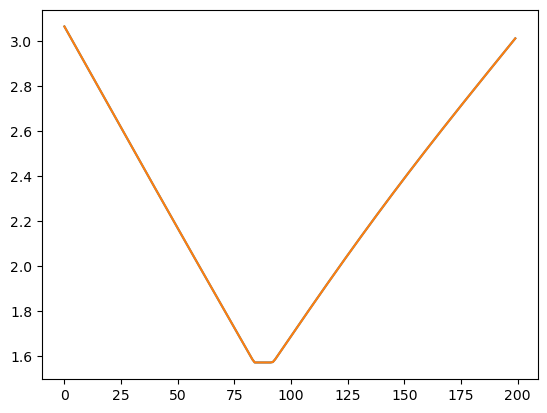

initial state is [1.27623561 1.89734943 3.0637809  2.66426015]
first reference goal state is [1.27564805 2.37044774 3.06386031 3.66739345]
end of horizon goal state is [-0.75786179  4.5444529   3.01095577  3.04906915]
optimal input is [-0.09433753  1.99997983]
end of horizon predicted state is [-1.58782227  4.71291805  3.0478467   2.84069474]


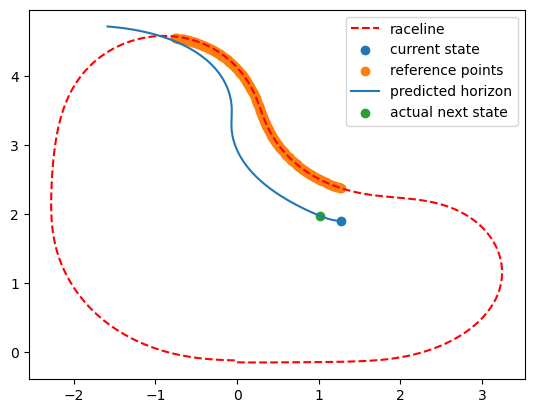

=================== new iteration ===================


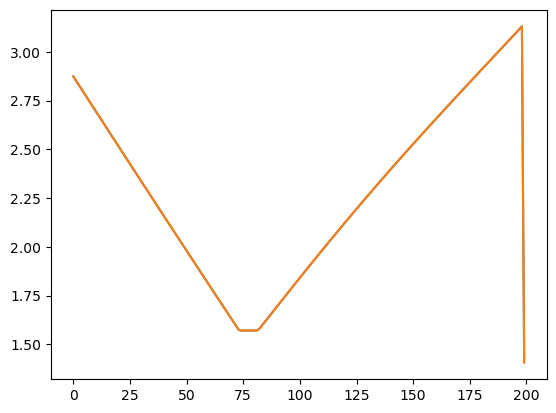

initial state is [1.01845897 1.97545886 2.73601537 2.73388593]
first reference goal state is [1.10830747 2.44387006 2.87392429 3.67105815]
end of horizon goal state is [-0.89895865  4.55368222  1.40705839  3.05865636]
optimal input is [-0.09339029  1.99922477]
end of horizon predicted state is [-1.81146821  4.72081425  2.83443082  2.99788338]


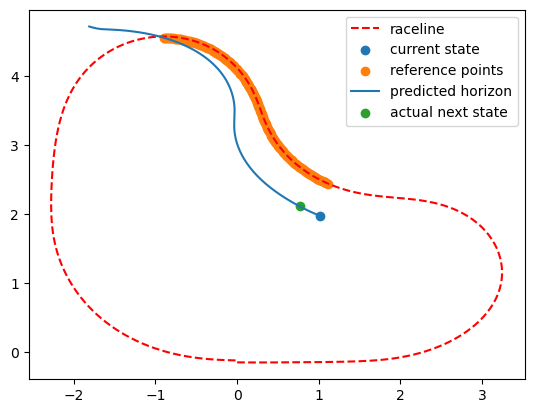

=================== new iteration ===================


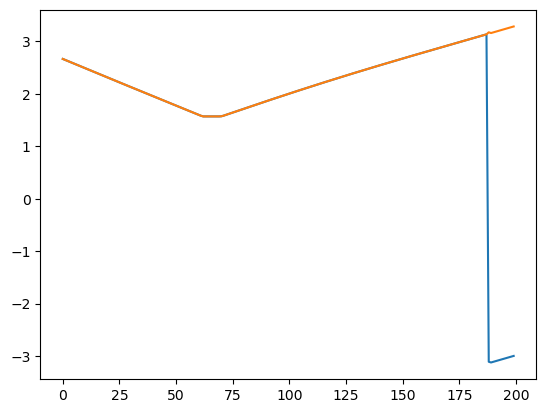

initial state is [0.77073944 2.11312941 2.57704929 2.93007406]
first reference goal state is [0.94612175 2.53895823 2.66704083 3.66459595]
end of horizon goal state is [-1.05352027  4.54272447  3.28593258  3.08488499]
optimal input is [-0.10742408 -1.99991238]
end of horizon predicted state is [-2.06039487  4.61321642  3.18854285  2.99994765]


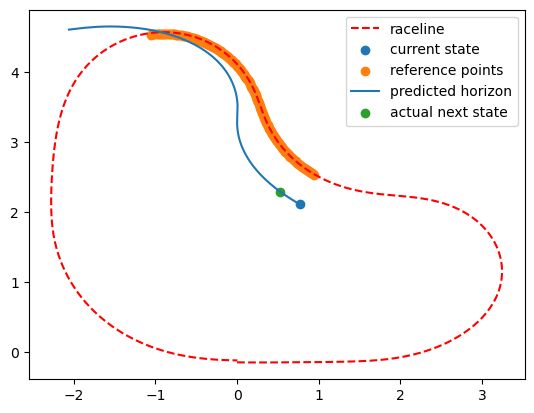

=================== new iteration ===================


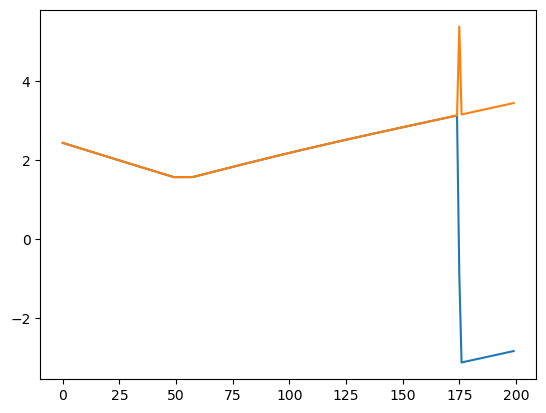

initial state is [0.52685271 2.2917487  2.46895696 3.1185449 ]
first reference goal state is [0.78710941 2.66118912 2.43840326 3.64933402]
end of horizon goal state is [-1.22313428  4.50523322  3.44703036  3.12590111]
[MPC] Solver failed: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1336: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'
  X0: [0.52685271 2.2917487  2.46895696 3.1185449 ]
optimal input is [0. 0.]
end of horizon predicted state is [0.52685271 2.2917487  2.46895696 3.1185449 ]


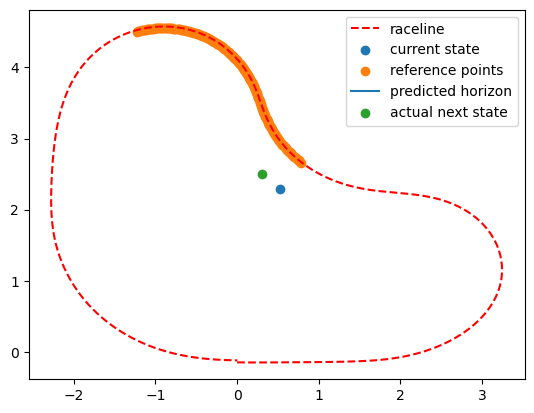

=================== new iteration ===================


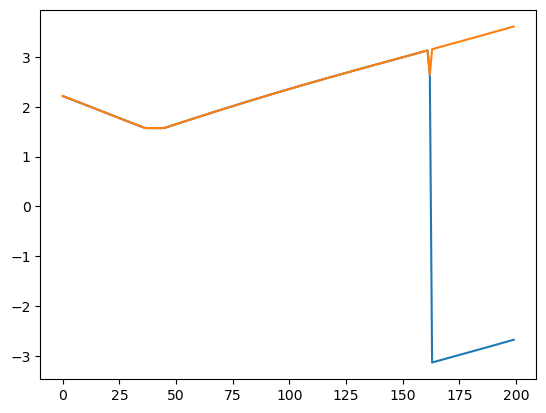

initial state is [0.30589045 2.49599161 2.34770461 2.90330881]
first reference goal state is [0.64833221 2.79979251 2.21349869 3.63059519]
end of horizon goal state is [-1.38593721  4.44245223  3.60849717  3.17189829]
optimal input is [-0.18096089 -1.99999761]
end of horizon predicted state is [-2.57853039  4.37783296  3.43392789  2.99998766]


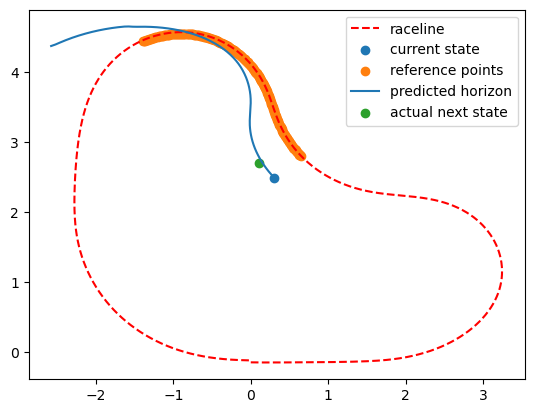

=================== new iteration ===================


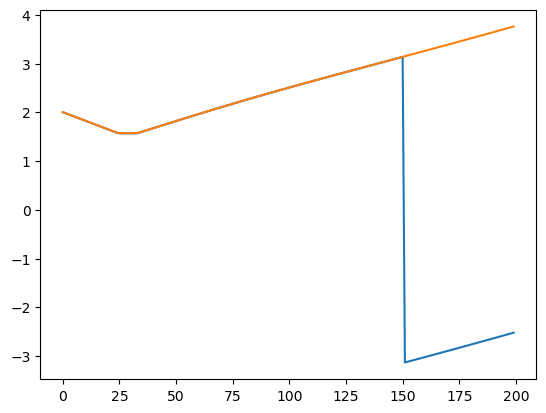

initial state is [0.10614697 2.70671416 2.32163963 2.90341364]
first reference goal state is [0.53339617 2.94773733 2.00374746 3.61348147]
end of horizon goal state is [-1.53131836  4.36096465  3.7620326   3.21713556]
optimal input is [-0.39999695 -1.99999954]
end of horizon predicted state is [-0.34060663  4.58480791 -1.41795478  2.99999011]


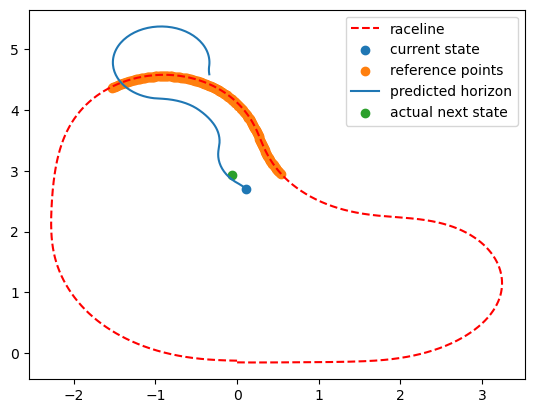

=================== new iteration ===================


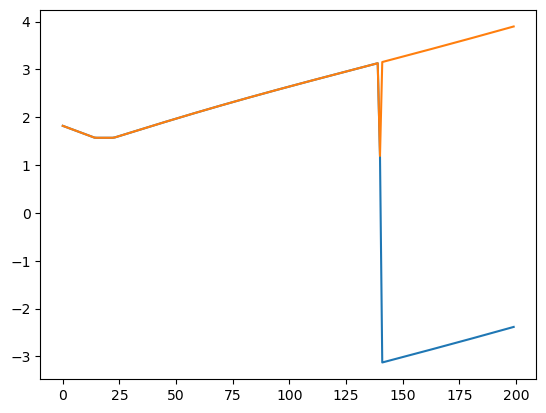

initial state is [-0.06602985  2.92409981  2.18877519  2.657203  ]
first reference goal state is [0.44458756 3.09401808 1.82075459 3.60192378]
end of horizon goal state is [-1.65090572  4.27209191  3.89836291  3.25930433]
optimal input is [-0.39999422 -1.99999933]
end of horizon predicted state is [-0.44565449  3.98047647 -1.73356801  2.99999189]


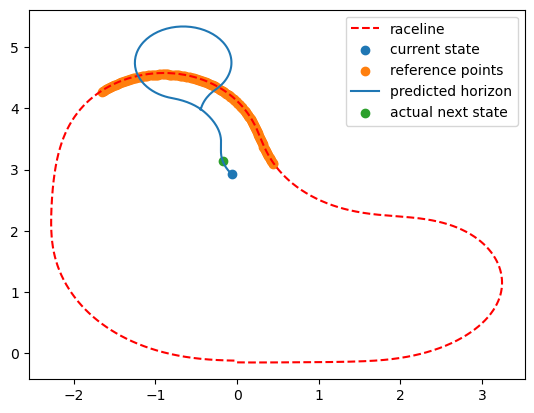

=================== new iteration ===================


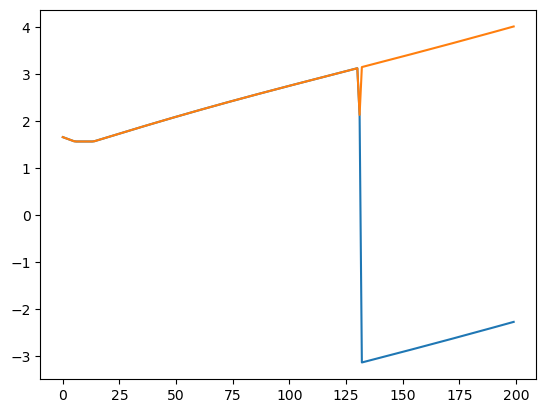

initial state is [-0.1770771   3.14732553  1.9606528   2.33622349]
first reference goal state is [0.3772754  3.23440685 1.66383274 3.59871598]
end of horizon goal state is [-1.74668084  4.18304894  4.01699759  3.29848641]
optimal input is [-0.28135276 -1.9999994 ]
end of horizon predicted state is [-0.61106573  3.79865247 -1.65258412  2.99999622]


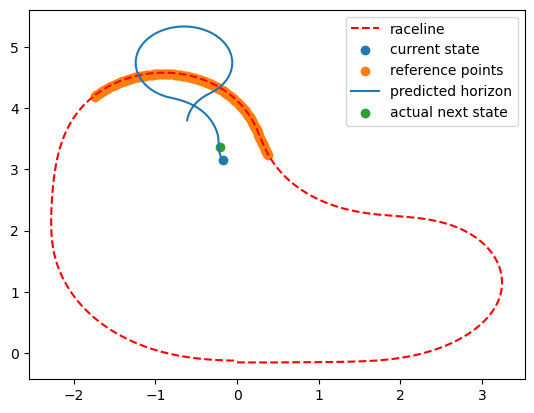

=================== new iteration ===================


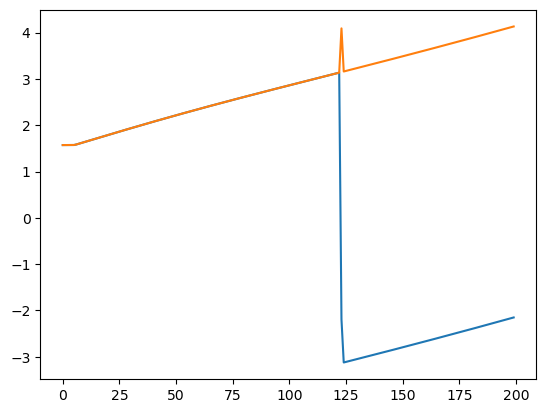

initial state is [-0.21168517  3.36265562  1.66439105  2.03648454]
first reference goal state is [0.32083987 3.38302047 1.57079633 3.60572692]
end of horizon goal state is [-1.83120856  4.0874744   4.13154165  3.33922677]
optimal input is [ 0.30347648 -1.99999835]
end of horizon predicted state is [-0.75705267  3.56221932 -1.56155423  2.99999668]


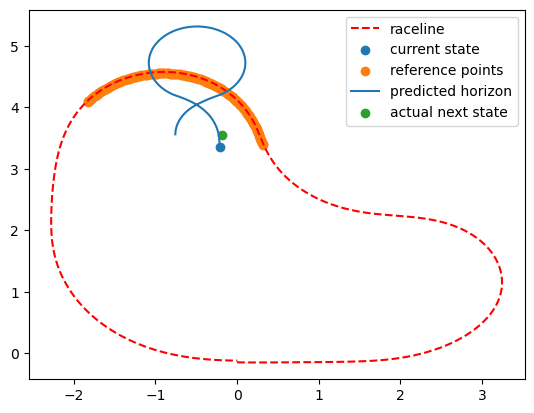

=================== new iteration ===================


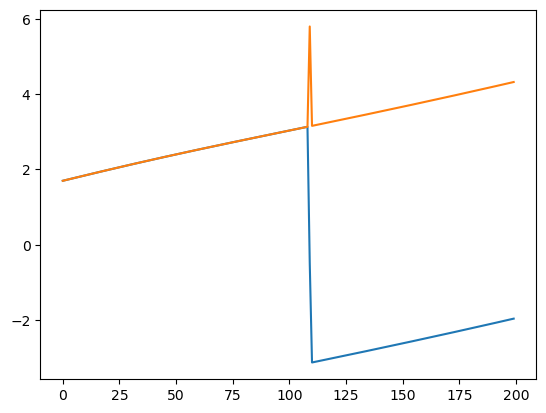

initial state is [-0.18810857  3.55574164  1.43261392  1.83427711]
first reference goal state is [0.24425629 3.62210378 1.69869439 3.60280144]
end of horizon goal state is [-1.9530799  3.9102001  4.3211853  3.4152569]
optimal input is [ 0.39999981 -1.99962876]
end of horizon predicted state is [-0.76808543  3.35041223 -1.38219164  2.99999498]


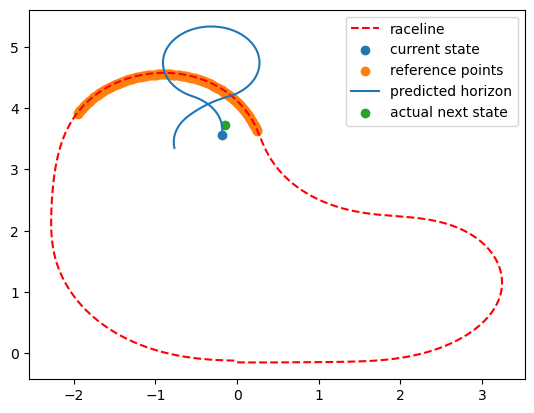

=================== new iteration ===================


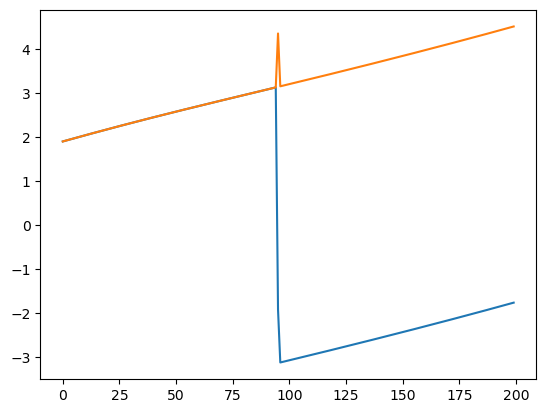

initial state is [-0.15341703  3.72288218  1.39649771  1.55795739]
first reference goal state is [0.15598611 3.84068242 1.90451134 3.52447483]
end of horizon goal state is [-2.05647465  3.7001682   4.52049775  3.50926425]
optimal input is [0.39999993 1.99999908]
end of horizon predicted state is [-0.51438334  3.14868293 -1.19716639  2.92168613]


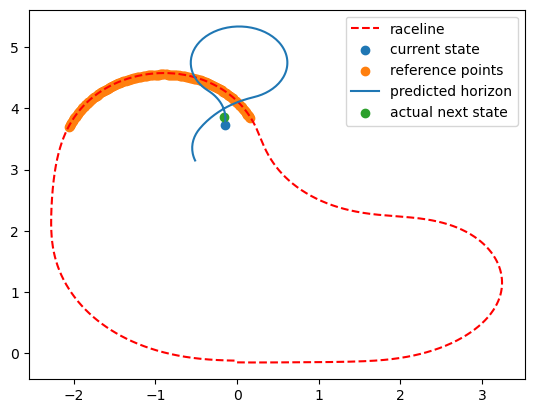

=================== new iteration ===================


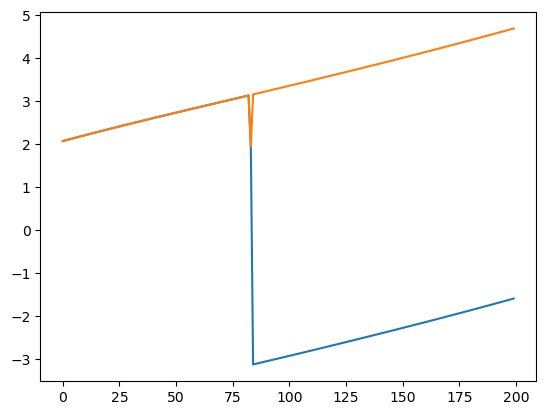

initial state is [-0.16247435  3.86512362  1.59643884  1.30103711]
first reference goal state is [0.06666641 3.99971542 2.06868659 3.43833863]
end of horizon goal state is [-2.12460425  3.50546847  4.68767637  3.60095173]
optimal input is [0.39999992 1.99999971]
end of horizon predicted state is [-0.25558308  3.02678407 -1.01850775  2.95516394]


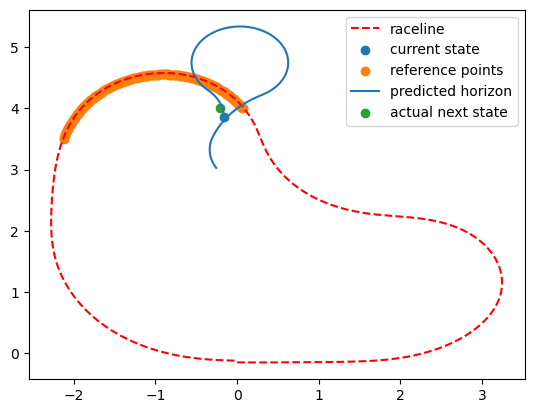

=================== new iteration ===================


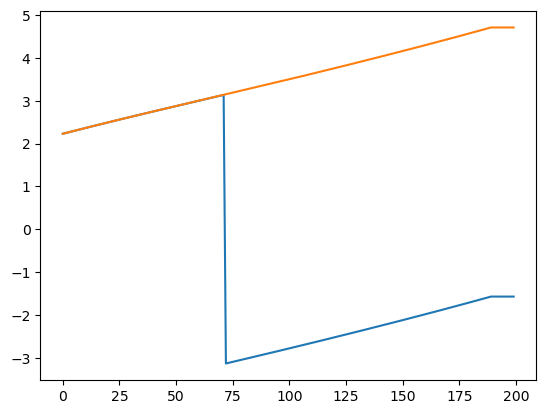

initial state is [-0.2056281   3.99939745  1.81569347  1.48116768]
first reference goal state is [-0.0390583   4.14190073  2.2306749   3.34315532]
end of horizon goal state is [-2.17830841  3.2917385   4.71238898  3.70513549]
optimal input is [0.39999994 1.99999985]
end of horizon predicted state is [-0.2321133   2.88093581 -0.8944899   2.88861055]


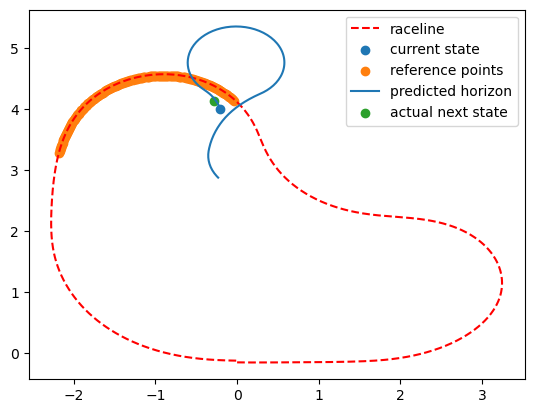

=================== new iteration ===================


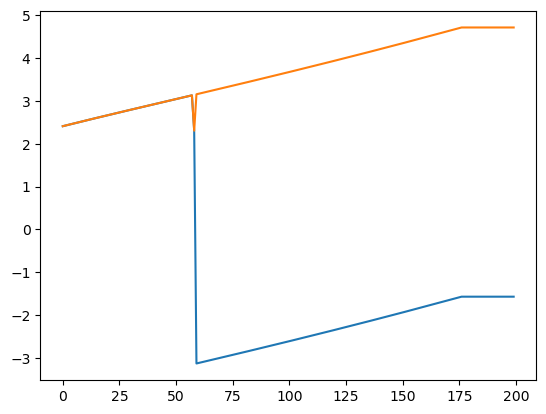

initial state is [-0.28653751  4.13603234  2.06101426  1.65681039]
first reference goal state is [-0.1745635   4.27845414  2.408208    3.23827647]
end of horizon goal state is [-2.22059102  3.04276038  4.71238898  3.82673622]
optimal input is [0.39999955 1.99999973]
end of horizon predicted state is [-0.18929922  2.67468348 -0.87713435  2.85501207]


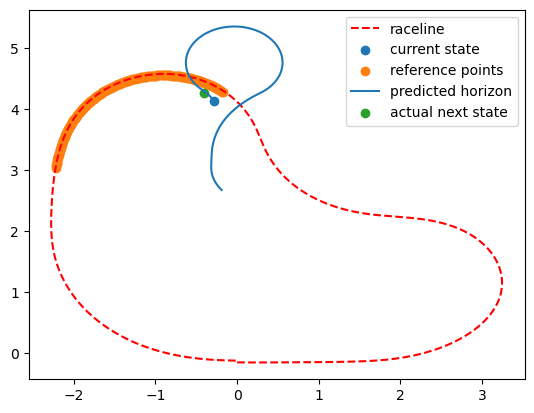

=================== new iteration ===================


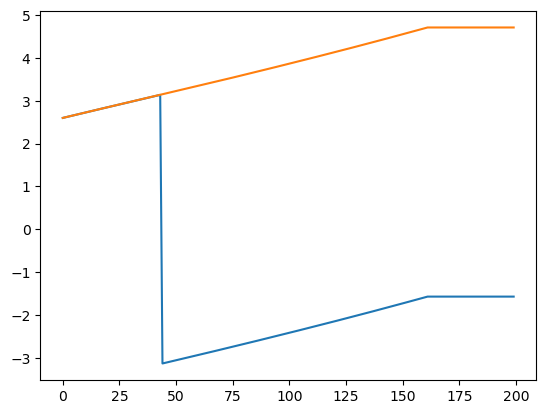

initial state is [-0.41049686  4.26076335  2.33157216  1.82554855]
first reference goal state is [-0.34299137  4.39985798  2.60074046  3.13994527]
end of horizon goal state is [-2.25108922  2.75444085  4.71238898  3.96052476]
optimal input is [-0.39999986  1.99999974]
end of horizon predicted state is [-0.14455975  2.42055528 -0.86071937  2.9055492 ]


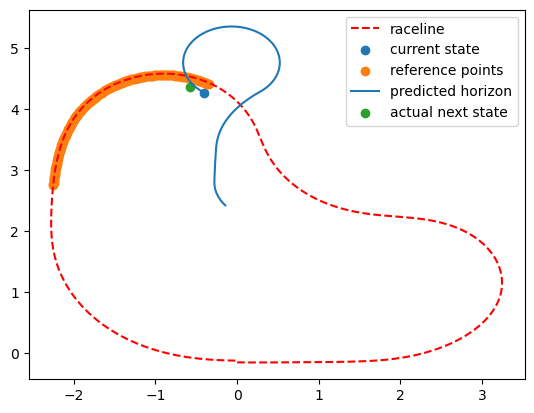

=================== new iteration ===================


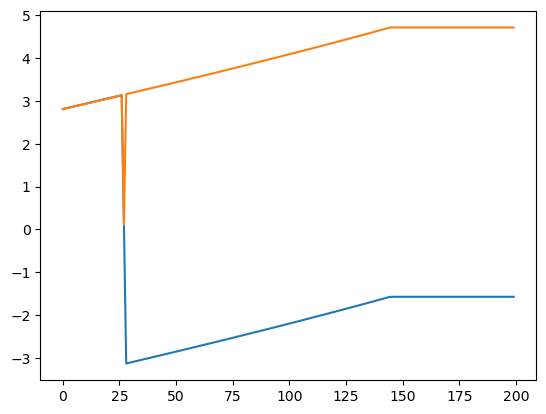

initial state is [-0.57732489  4.35580689  2.62547216  1.98494717]
first reference goal state is [-0.54546306  4.49409214  2.80818862  3.07030841]
end of horizon goal state is [-2.27043876  2.42393846  4.71238898  4.09559889]
optimal input is [-0.4         1.99999988]
end of horizon predicted state is [-0.18045489  2.140139   -0.8285979   2.99999899]


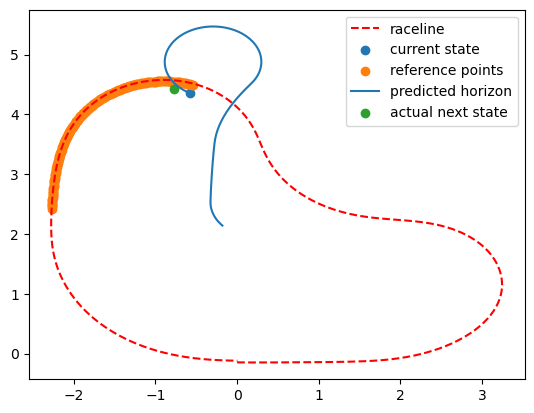

=================== new iteration ===================


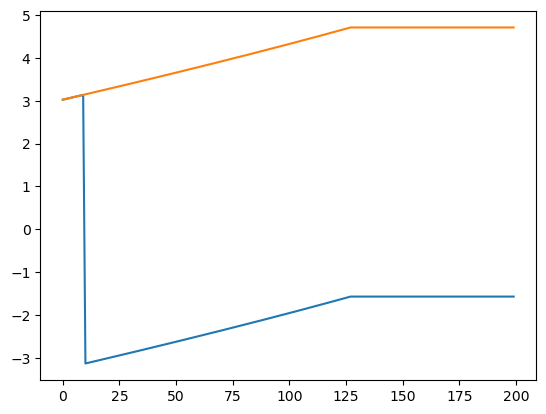

initial state is [-0.77085392  4.43112065  2.75741265  2.13274401]
first reference goal state is [-0.77435888  4.54649674  3.02636951  3.0493832 ]
end of horizon goal state is [-2.27601897  2.05973633  4.71238898  4.21105327]
optimal input is [-0.39999999  1.99999969]
end of horizon predicted state is [-0.19123484  1.85023883 -0.81513487  2.99999791]


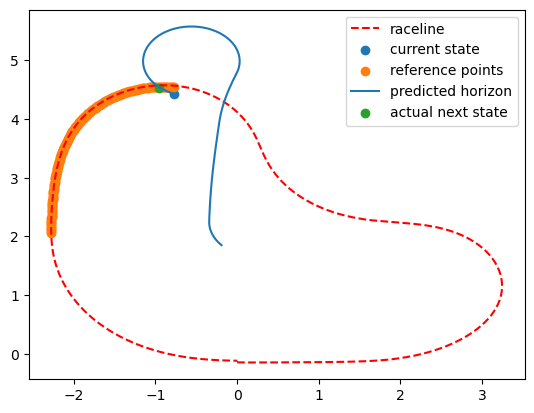

=================== new iteration ===================


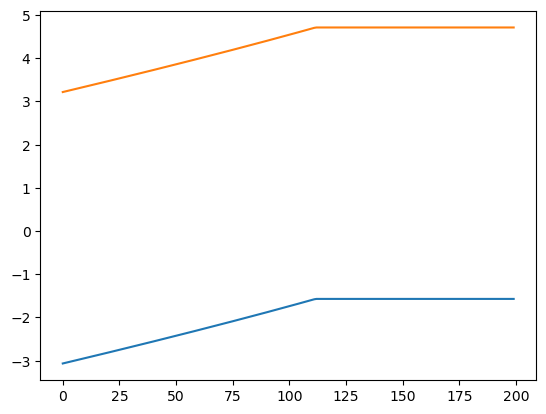

initial state is [-0.96029261  4.53619297  2.60340815  2.19954458]
first reference goal state is [-0.98048385  4.55063057  3.21781535  3.07080979]
end of horizon goal state is [-2.25713046  1.7335474   4.71238898  4.26301951]
optimal input is [-0.4         1.99999977]
end of horizon predicted state is [-0.17336085  1.75060317 -0.81786233  2.99999798]


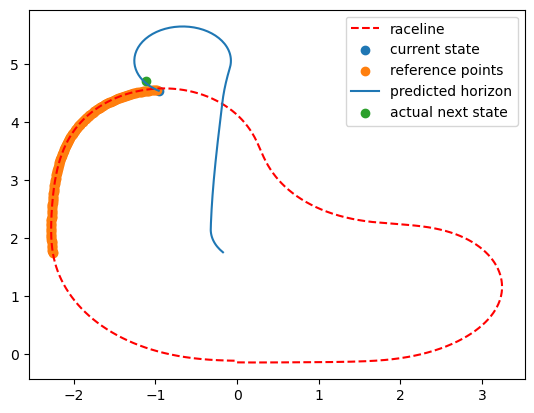

=================== new iteration ===================


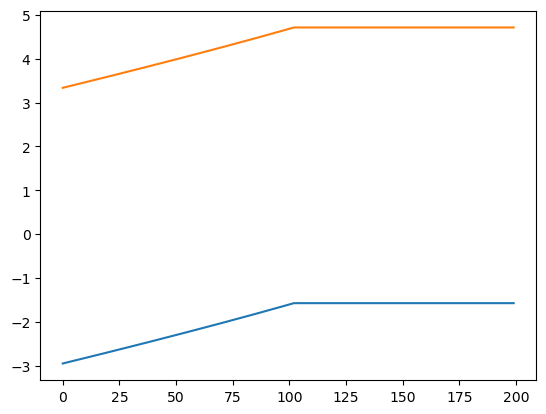

initial state is [-1.1174775   4.69794038  2.28949611  2.30911262]
first reference goal state is [-1.10861922  4.53350757  3.33771688  3.09715479]
end of horizon goal state is [-2.22573613  1.52978309  4.71238898  4.26197964]
optimal input is [-0.40000001  1.99999991]
end of horizon predicted state is [-0.19010635  1.56865047 -0.81703315  2.99999913]


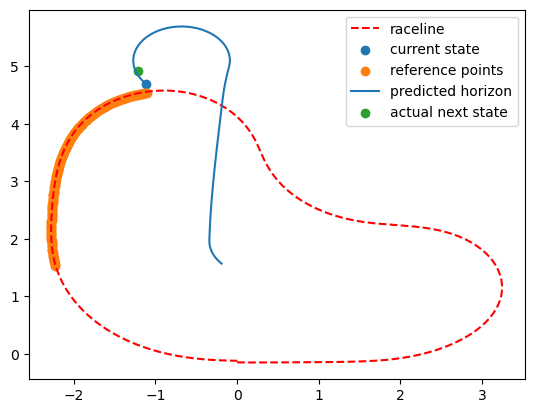

=================== new iteration ===================


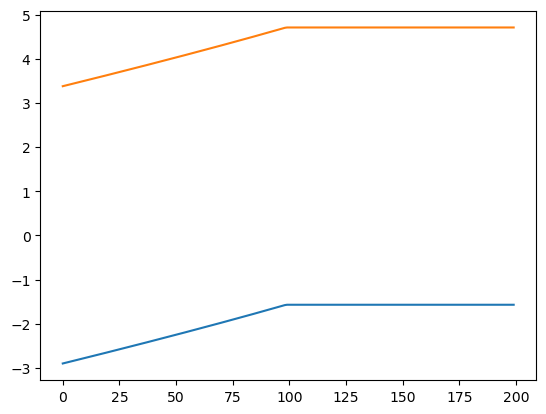

initial state is [-1.2199347   4.91121518  1.94127388  2.41937315]
first reference goal state is [-1.15491723  4.52358552  3.38159422  3.10833125]
end of horizon goal state is [-2.20968255  1.45575209  4.71238898  4.25617326]
optimal input is [-0.4         1.99999974]
end of horizon predicted state is [-0.24547925  1.37449719 -0.81164425  2.99999797]


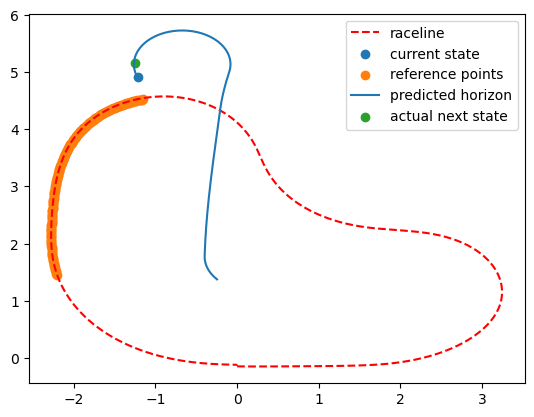

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-05-13 11:41:27.229 | INFO     | __main__:<module>:92 - Average lap time: nan s. Std: nan s.
2025-05-13 11:41:27.229 | INFO     | __main

Saved log to mpc_log_20250513-114127.csv


In [27]:
import pandas as pd
import time
# Create an instance of the simulator.
# path_follower = PIDRacelineFollower(dt=dt, steer_pid_params=pid_steer_params_raceline_follower, speed_pid_params=pid_speed_params_raceline_follower)
raceline = Raceline()
seed = 42

env = gym.make('barc-v0',
               track_name='L_track_barc',
               do_render=True,
               max_n_laps=5,  # Feel free to modify this.
               in_colab=True,
               )
# env.unwrapped.bind_controller(path_follower)

# Reset the car to the starting line, with an initial velocity of 0.5 m/s.
_, info = env.reset(seed=seed, options={'spawning': 'fixed'})

truncated = False # Flag indicating whether the car is at a terminal state.

lap_time = []  # Keep track of the lap times.

model = BicycleModel(L=0.25,dt=0.01)
controller = MPCController(model)
spd_scale = 0.5


steer_MPC = []
steer_cmd_Msg = []
steer_actual_Msg = []
t_Msg = []
pose_error_Msg = []

def unwrap_angle(angle_list):
    if angle_list[0] < 0:
        angle_list = [angle + 2 * np.pi for angle in angle_list]
    return  np.unwrap(angle_list)


while not truncated:
# for i in range(1000):
    print('=================== new iteration ===================')

    # extract states -------------------------------------------
    initial_state = extract_initial_state(info['vehicle_state'])
    goal_state = raceline.get_MPC_reference(info['vehicle_state'].p.s, controller, initial_state[3],spd_scale)
    plt.plot(goal_state[2])

    psi_unwrap = unwrap_angle(goal_state[2])
    goal_state[2] = psi_unwrap
    
    plt.plot(psi_unwrap)
    plt.show()
    print('initial state is',initial_state)
    print('first reference goal state is',goal_state[:,0])
    print('end of horizon goal state is',goal_state[:,-1])

    # MPC -------------------------------------------
    u,x = controller.solve(initial_state, goal_state)
    print("optimal input is",u)
    print("end of horizon predicted state is",x[:,-1])
    action = np.array([u[1], u[0]]) # sim takes [acceleration, steering]

    steer_MPC.append(u[0])
    t_Msg.append(info['vehicle_state'].t)

    ax = plt.gca()
    raceline.plot_raceline(ax)
    plt.scatter (initial_state[0],initial_state[1],label="current state")
    plt.scatter (goal_state[0,:],goal_state[1,:],label="reference points")
    plt.plot(x[0,:],x[1,:],label="predicted horizon")

    # SIM -------------------------------------------
    _, _, terminated, truncated, info = env.step(action) # Apply the action on the car and get the updated state.

    # extract steer data
    steer_cmd_Msg.append(info['vehicle_state'].u.u_steer)
    steer_actual_Msg.append(info['vehicle_state'].hw.steering)
    pose_error_Msg.append([info['vehicle_state'].p.x_tran,info['vehicle_state'].p.e_psi])


    # extract and plot propagated state
    end_state = extract_initial_state(info['vehicle_state'])
    plt.scatter (end_state[0],end_state[1],label="actual next state")
    plt.legend()
    plt.show()


    if terminated:
        lap_time.append(info['lap_time'])  # Keep track of the time it took to finish a lap.

logger.info(f"Average lap time: {np.mean(lap_time):.1f} s. Std: {np.std(lap_time):.1f} s.")
logger.info("Rollout truncated.")

# Convert pose error log to a DataFrame
pose_error_df = pd.DataFrame({
    "time": t_Msg,
    "x_tran": [p[0] for p in pose_error_Msg],
    "e_psi": [p[1] for p in pose_error_Msg],
})

timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"mpc_log_{timestamp}.csv"
filenames.append(filename)

pose_error_df.to_csv(filename, index=False)
print(f"Saved log to {filename}")

##Create Plots

['mpc_log_20250512-213701.csv']


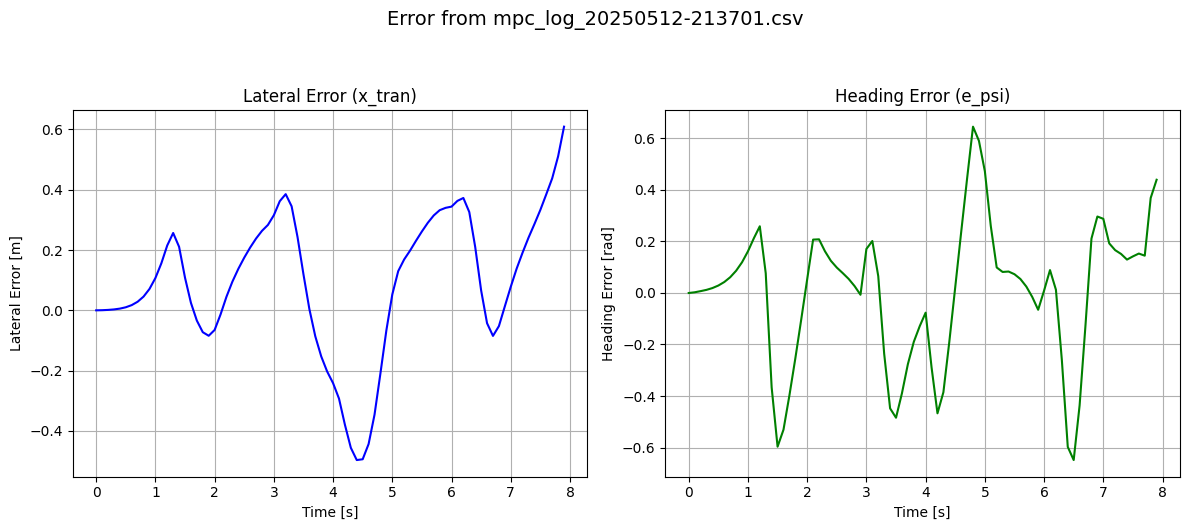

In [13]:
print(filenames)
df = pd.read_csv(filenames[0])
df.head()
# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Add a suptitle (super title for the whole figure)
fig.suptitle(f"Error from {filename}", fontsize=14, y=1.05)

# Plot lateral error
axes[0].plot(df["time"], df["x_tran"], color="blue")
axes[0].set_title("Lateral Error (x_tran)")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Lateral Error [m]")
axes[0].grid(True)

# Plot heading error
axes[1].plot(df["time"], df["e_psi"], color="green")
axes[1].set_title("Heading Error (e_psi)")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Heading Error [rad]")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for the suptitle
plt.show()


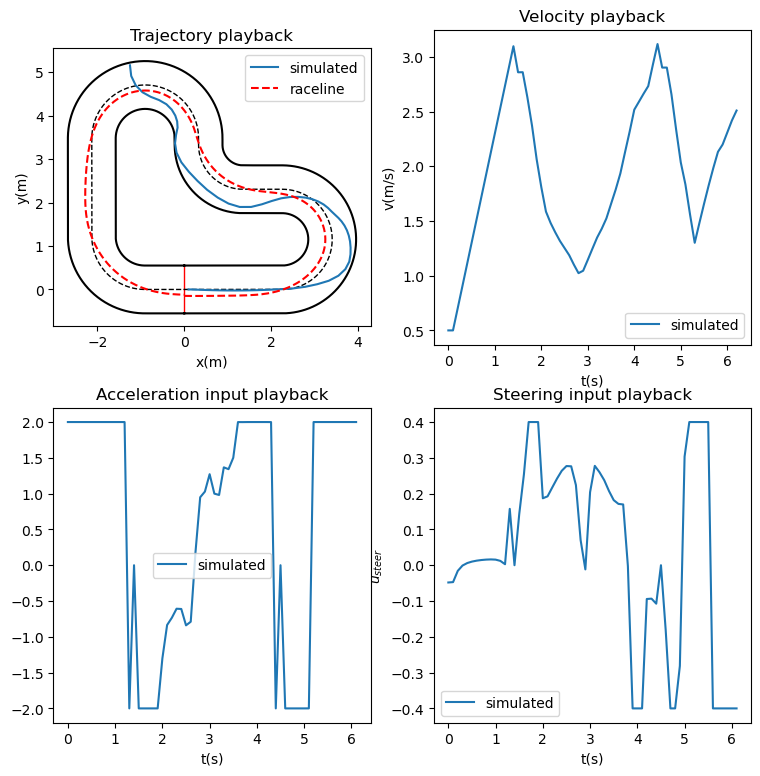

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
env.unwrapped.show_debug_plot(axes)
raceline.plot_raceline(ax=axes[0][0])
for ax in axes.flatten():
    ax.legend()
plt.show()

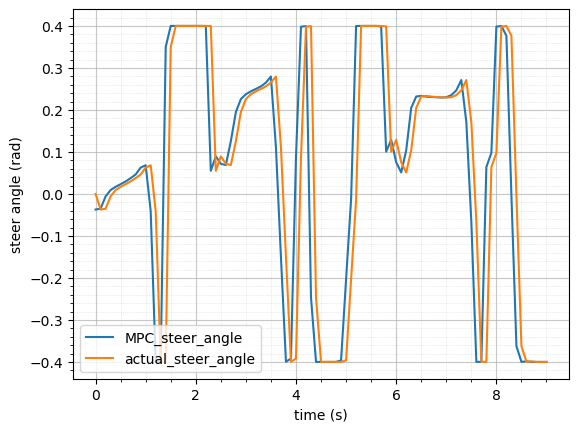

In [18]:
plt.plot(t_Msg,steer_MPC,label="MPC_steer_angle")
plt.plot(t_Msg,steer_cmd_Msg,label="actual_steer_angle")
# plt.plot(steer_actual_Msg,label="actual_steer_Msg")

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('steer angle (rad)')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.show()

In [29]:

a1 = -2.04
a2 = 2 * np.pi + a1
b = 4.11

print(ca.atan2(ca.sin(a1-b),ca.cos(a1-b)))
print(ca.atan2(ca.sin(a2-b),ca.cos(a2-b)))

0.13318530717958613
0.13318530717958588


In [57]:
list = np.array([np.pi, 2*np.pi, np.pi])
print(list % np.pi)


np.unwrap(list, discont=np.pi/2)

[0. 0. 0.]


array([3.14159265, 6.28318531, 3.14159265])

In [ ]:
psi_unwrap = np.unwrap(ref_state_list[:][2], discont=2*np.pi-0.1)

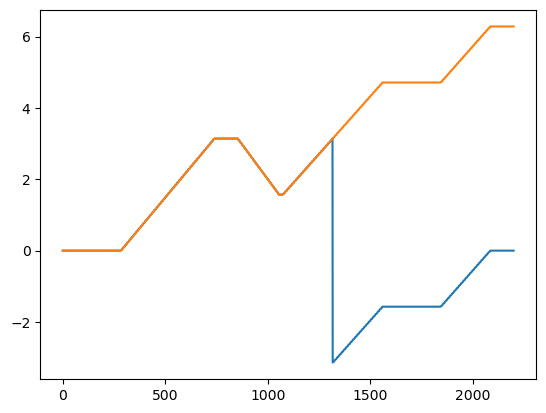

In [18]:
psi_test = raceline.get_psi_test()



plt.plot (psi_test)
plt.plot (np.unwrap(psi_test))